In [1]:
import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense

# Method to build confusion matrix for various classifiers
def create_confusion(expected, predicted, axis_labels):
    
    # argmax() used to remove one-hot encoding
    cm = confusion_matrix(expected.argmax(axis=1), predicted.argmax(axis=1))
    cm = pd.DataFrame(cm, index = [i for i in axis_labels], columns = [i for i in axis_labels])
    plt.figure(figsize=(30, 21))
    sns.heatmap(cm, annot=True)

# Method to develop roc curves for each label and print
def roc_auc(expected, predicted, number_of_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
              'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    
    for i in range(number_of_classes):
        fpr[i], tpr[i], _ = roc_curve(expected[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    for i in range(number_of_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC Curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.xlim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if(i < 10):
            plt.title('Reciever Operating Characteristic for Label %0.0f' % i)
        else:
            string = 'Reciever Operating Characteristic for Label ' + letters[i-10]
            plt.title(string)
        plt.legend(loc='lower right')
        plt.show
        
    macro_roc_auc_ovo = roc_auc_score(expected, predicted, multi_class='ovo', average='macro')
    weighted_roc_auc_ovo = roc_auc_score(expected, predicted, multi_class='ovo', average='weighted')

    macro_roc_auc_ovr = roc_auc_score(expected, predicted, multi_class='ovr', average='macro')
    weighted_roc_auc_ovr = roc_auc_score(expected, predicted, multi_class='ovr', average='weighted')

    print("One-vs-One ROC AUC scores:\n{:.6f} (macro), \n{:.6f} (weighted)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("\nOne-vs-Rest ROC AUC scores:\n{:.6f} (macro), \n{:.6f} (weighted)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
def process_image(image):
    image = cv2.imread(image)
    image = cv2.resize(image, (700, 500))
    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(grey.copy(), 100, 255, cv2.THRESH_BINARY_INV)
    _, contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    _, y1, _, _ = cv2.boundingRect(contours[0])

    preprocessed_digits = []
    x_coord = []
    y_coord = []
    y_row = []
    df = pd.DataFrame()

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
    
        # Cropping digit out of image
        digit = thresh[y:y+h, x:x+w]

        # Check size of digit to keep extraneous markings out of data
        if(digit.size > 325):

            if(y_row == []):
                y_row.append(y)

            # Create rectangle around each digit in image to display
            cv2.rectangle(image, (x, y), (x+w, y+h), color=(255, 0, 0))

            # Resizing digit to 18x18 to be centered in 28x28 in image
            resized_digit = cv2.resize(digit, (18,18))

            # Pad digit with 5 pixels of black on each side to have digit centered in 28x28 image
            padded_digit = np.pad(resized_digit, ((5,5),(5,5)), 'constant', constant_values=0)
            
            # Assigns each item a y_coordinate based on line it is on
            # Handles images with multiple lines of text
            y_flag = False
            for row_y in y_row:
                # Checks if item is within buffer range of any row
                if((y < (row_y + h/1)) and (y > row_y - h/1)):
                    y = row_y
                    y_flag = True
                if(y_flag == True):
                    break
            # If item is not within range of another row it starts its own row
            if(y_flag == False):
                y_row.append(y)


            # Appending final preprocessed digit to list
            preprocessed_digits.append(padded_digit)
            x_coord.append(x)
            y_coord.append(y)
    
    # Build dataframe containing all image info, their x-coordinates and row's y-coordinate
    df['Preprocessed_Digits'] = preprocessed_digits
    df['X_Coord'] = x_coord
    df['Y_Coord'] = y_coord
    
    # Sorting in order to process text line-by-line
    df = df.sort_values(by=['Y_Coord', 'X_Coord'], ascending=True)
    df = df.reset_index(drop=True)
    
    shaped_digits = []
    
    # Processed_digit features appended into list
    for digit in df['Preprocessed_Digits']:
        shaped_digits.append(digit)
    
    # Reshape 28x28 digit features into 1x784 array then normalize features
    shaped_digits = np.array(shaped_digits)
    shaped_digits = shaped_digits.reshape(shaped_digits.shape[0], 784).astype('float32')
    shaped_digits /= 255
    
    # Plot image with boxed digits
    plt.imshow(image, cmap='gray')
    plt.show
    
    # Return digit array and dataframe with coordinates
    return shaped_digits, df

Using TensorFlow backend.


# Digit Data

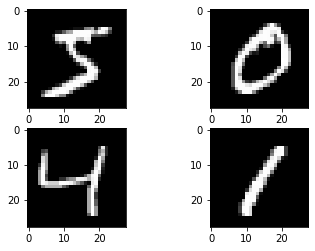

In [2]:
from keras.datasets import mnist

(X_train_num, y_train_num), (X_test_num, y_test_num) = mnist.load_data()

plt.subplot(221)
plt.imshow(X_train_num[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_num[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_num[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_num[3], cmap=plt.get_cmap('gray'))

In [3]:
# Flatten the 28x28 images into a 784 vector for each image

num_pixels = X_train_num.shape[1] * X_train_num.shape[2]
X_train_num = X_train_num.reshape((X_train_num.shape[0], num_pixels)).astype('float32')
X_test_num = X_test_num.reshape((X_test_num.shape[0], num_pixels)).astype('float32')

# Normalize inputs from values of 0-255 to 0-1

X_train_num = X_train_num / 255
X_test_num = X_test_num / 255

X_train_num

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
X_test_num

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
# One-hot encode label values from integer to categorical

from keras.utils import np_utils

y_train_ohe = np_utils.to_categorical(y_train_num)
y_test_ohe = np_utils.to_categorical(y_test_num)

num_classes = y_test_ohe.shape[1]
num_classes

10

## K-Nearest Neighbors with Digits

In [6]:
# KNearest Neighbors
knn_digit = KNeighborsClassifier(n_jobs=3)
knn_digit.fit(X_train_num, y_train_ohe)

KNeighborsClassifier(n_jobs=3)

In [7]:
knn_digit_predicted = knn_digit.predict(X_test_num)

In [8]:
expected = y_test_ohe.tolist()
print('Accuracy: ', accuracy_score(expected, knn_digit_predicted))

Accuracy:  0.966


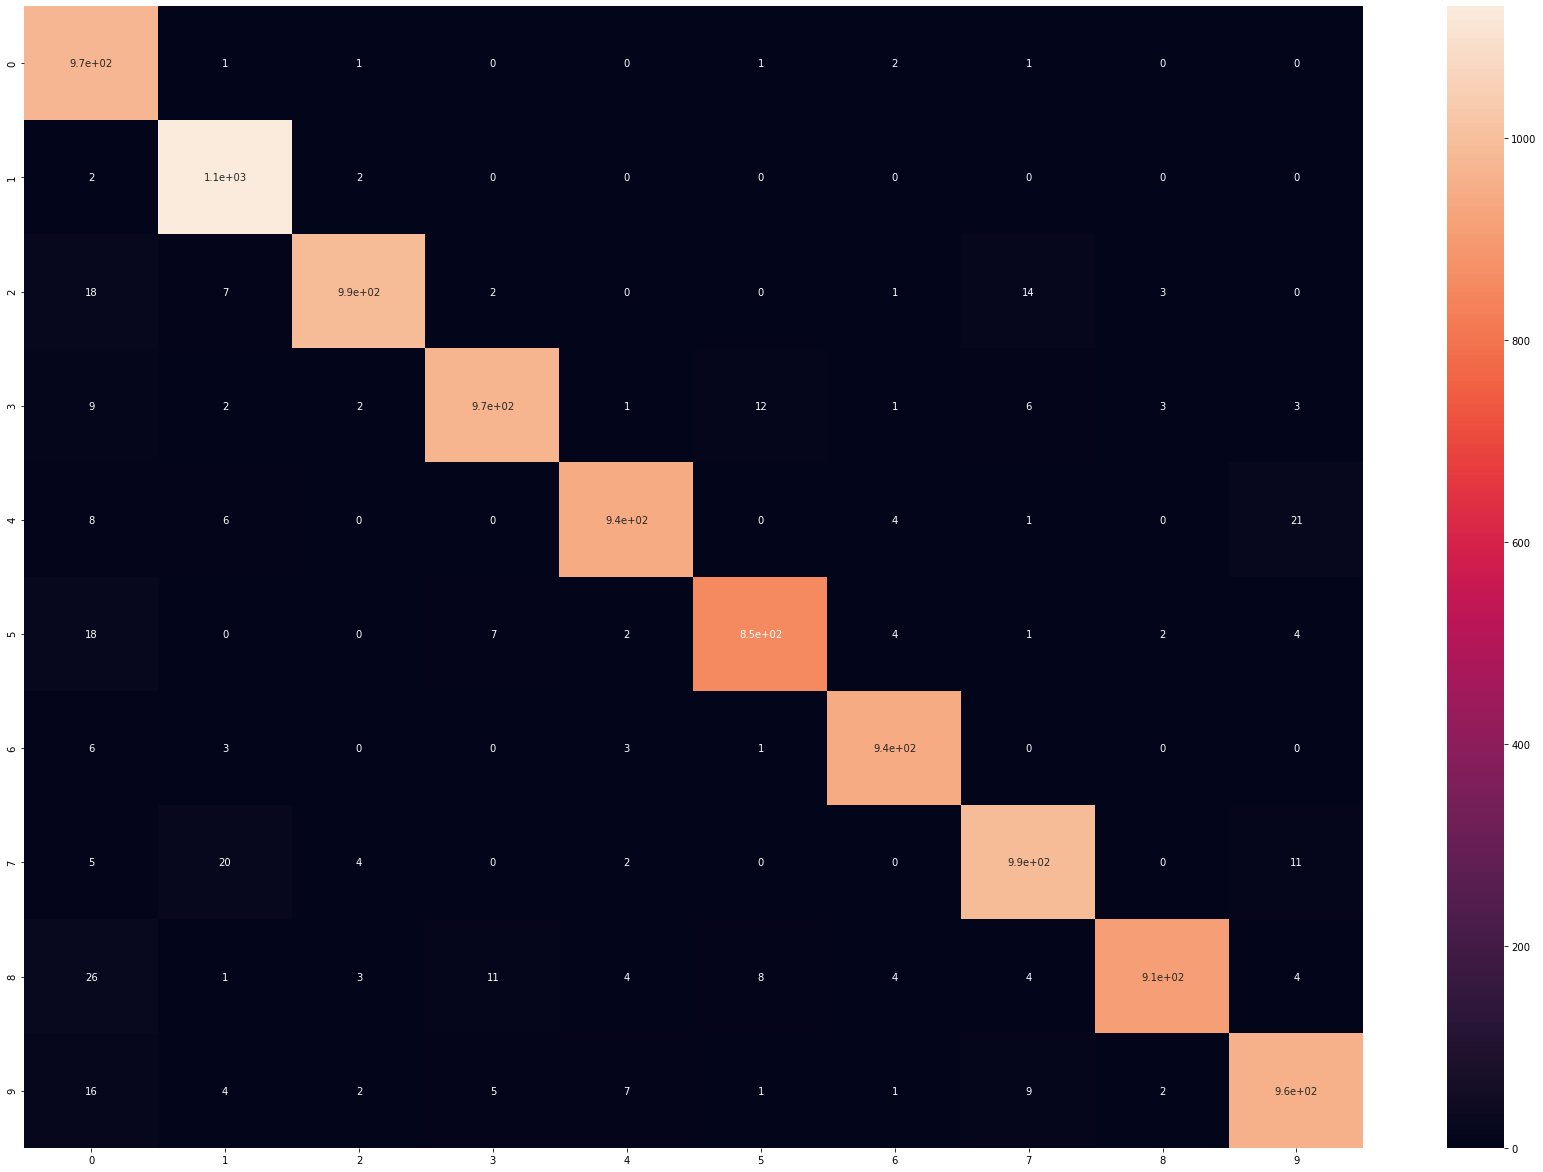

In [9]:
num_axis_labels = '0123456789'

create_confusion(y_test_ohe, knn_digit_predicted, num_axis_labels)

One-vs-One ROC AUC scores:
0.981361 (macro), 
0.981538 (weighted)

One-vs-Rest ROC AUC scores:
0.981361 (macro), 
0.981538 (weighted)


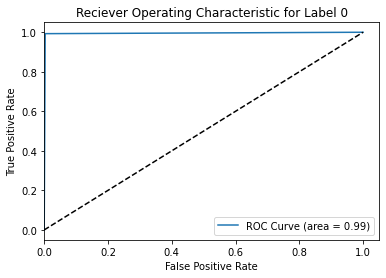

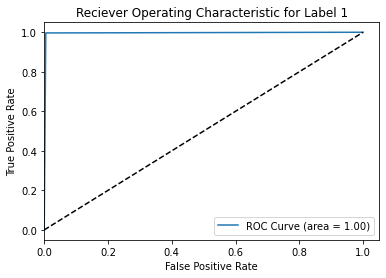

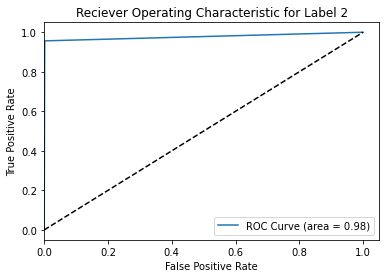

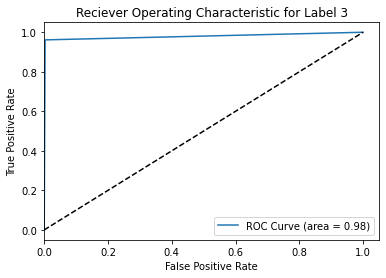

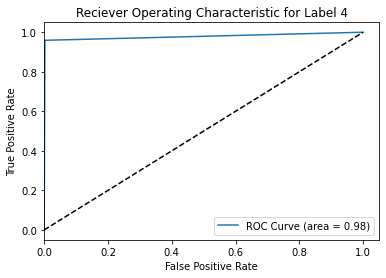

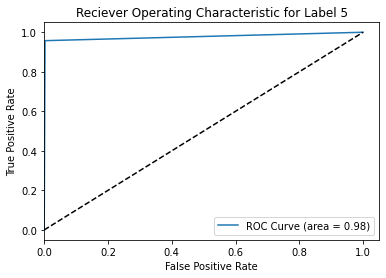

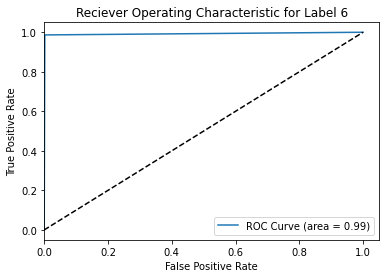

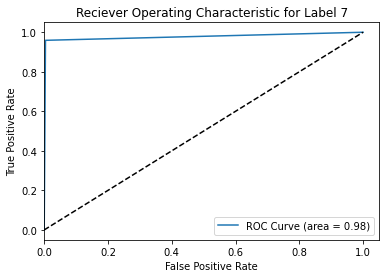

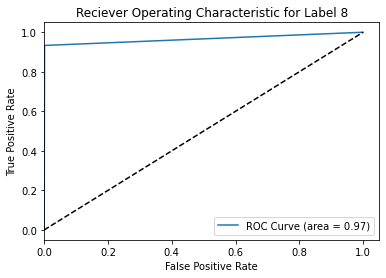

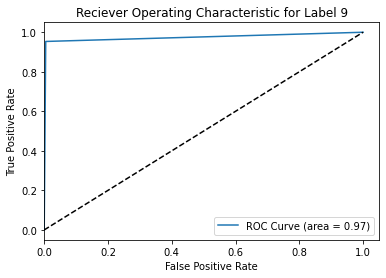

In [10]:
roc_auc(y_test_ohe, knn_digit_predicted, num_classes)

## Random Forest with Digits

In [11]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

random_forest_digit = RandomForestClassifier(n_estimators=100, n_jobs=3)
random_forest_digit.fit(X_train_num, y_train_ohe)

RandomForestClassifier(n_jobs=3)

In [12]:
forest_digit_predicted = random_forest_digit.predict(X_test_num)
print('Accuracy: ', accuracy_score(expected, forest_digit_predicted))

Accuracy:  0.9036


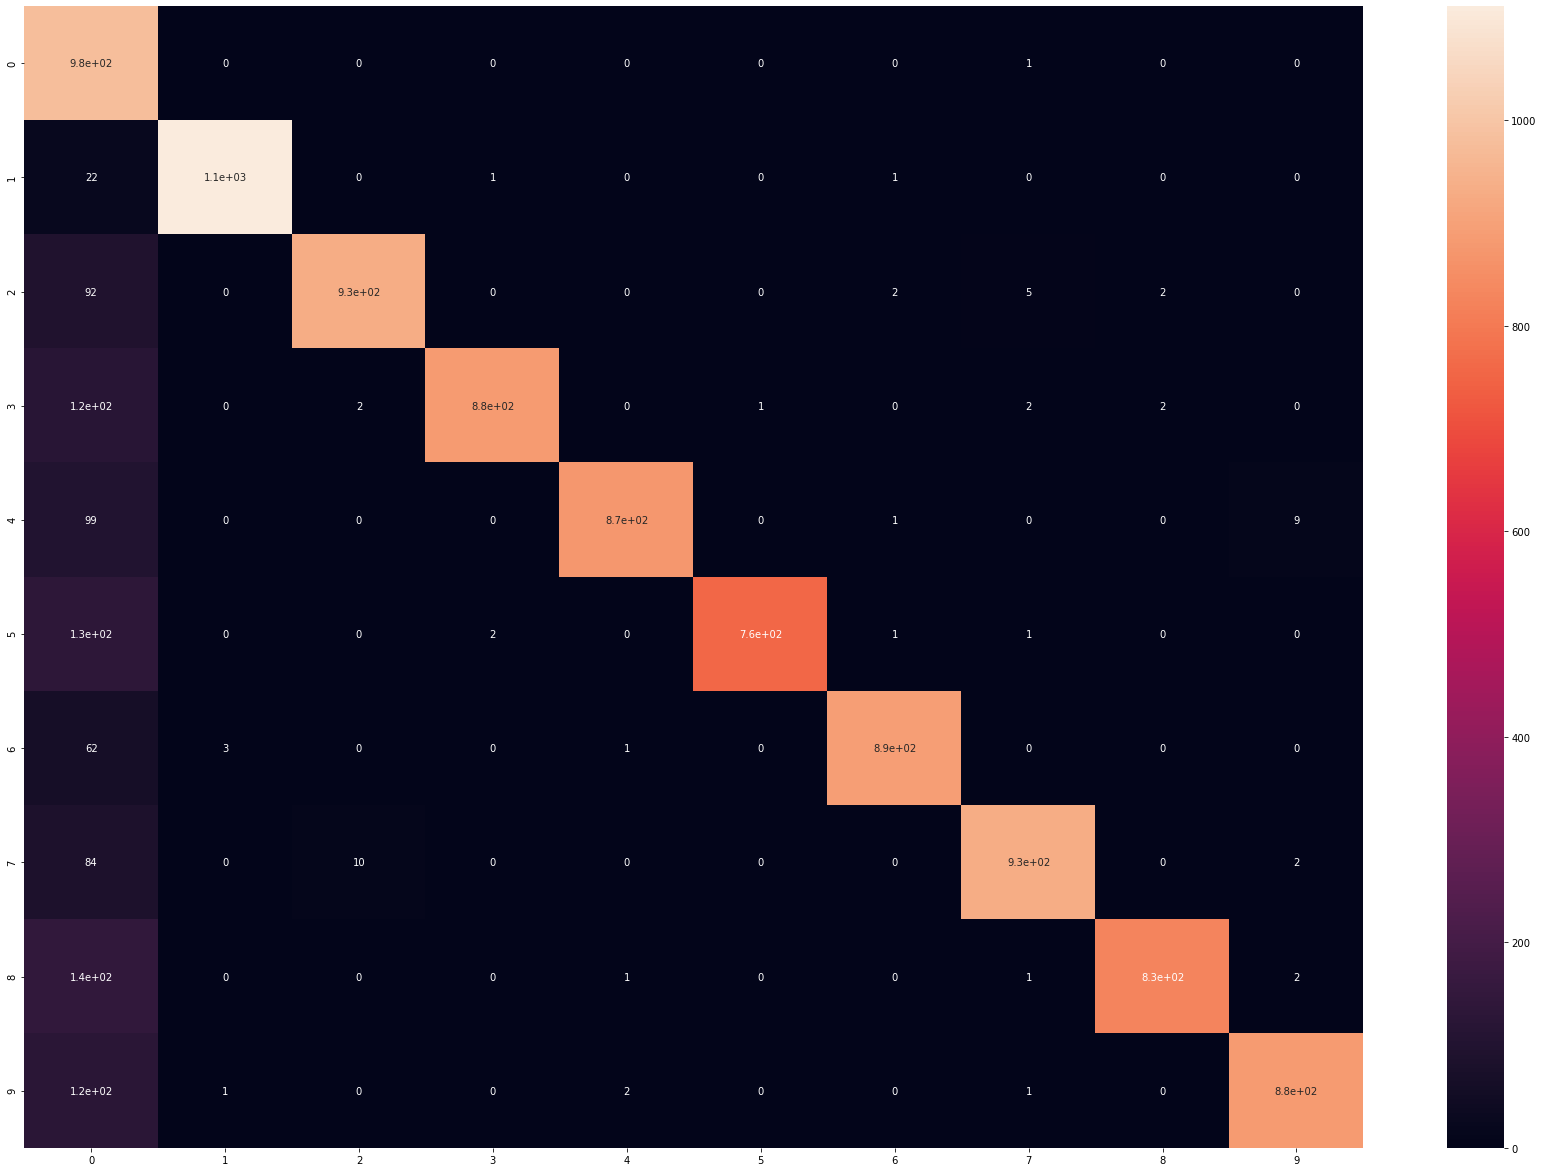

In [13]:
create_confusion(y_test_ohe, forest_digit_predicted, num_axis_labels)

One-vs-One ROC AUC scores:
0.950701 (macro), 
0.951440 (weighted)

One-vs-Rest ROC AUC scores:
0.950701 (macro), 
0.951440 (weighted)


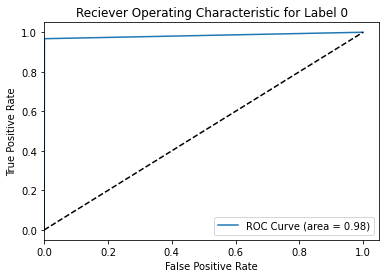

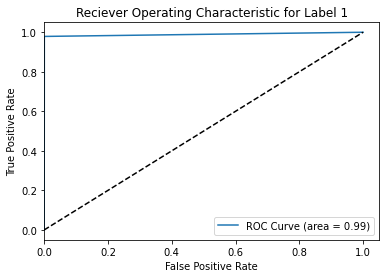

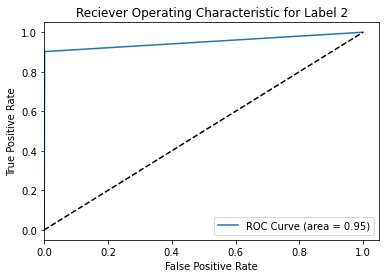

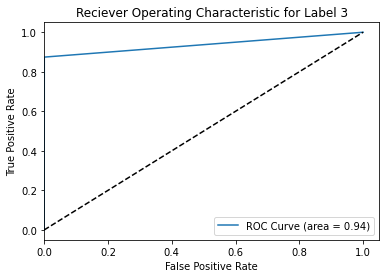

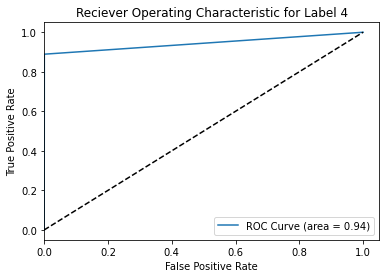

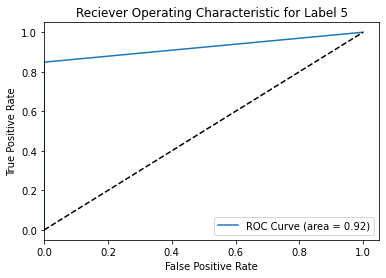

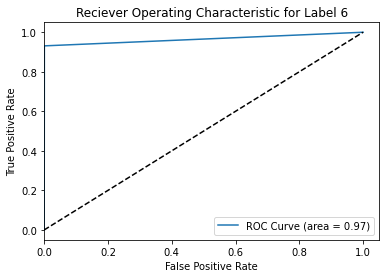

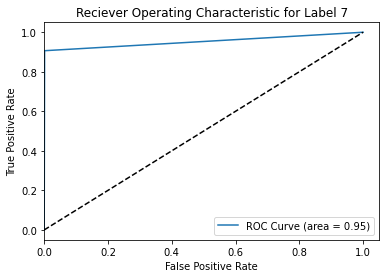

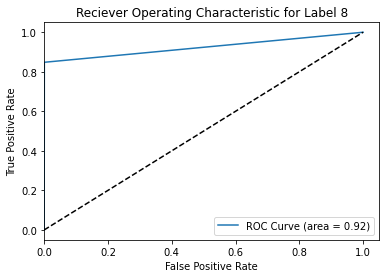

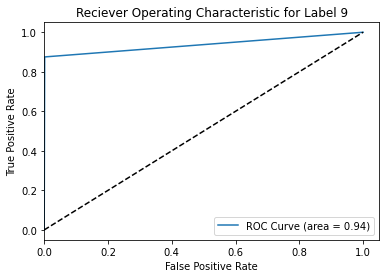

In [14]:
roc_auc(y_test_ohe, forest_digit_predicted, num_classes)

## Linear SVM with Digits

In [16]:
# Linear SVM (due to time consumption of using SVM with large dataset)

from sklearn.svm import LinearSVC

linear_svm_digit = LinearSVC(max_iter=10000)
linear_svm_digit.fit(X_train_num, y_train_num) # Does not take one-hot-encoded labels

LinearSVC(max_iter=10000)

In [17]:
linsvm_digit_predicted = linear_svm_digit.predict(X_test_num)
print('Accuracy: ', accuracy_score(np.argmax(expected, axis=1), linsvm_digit_predicted))

Accuracy:  0.9183


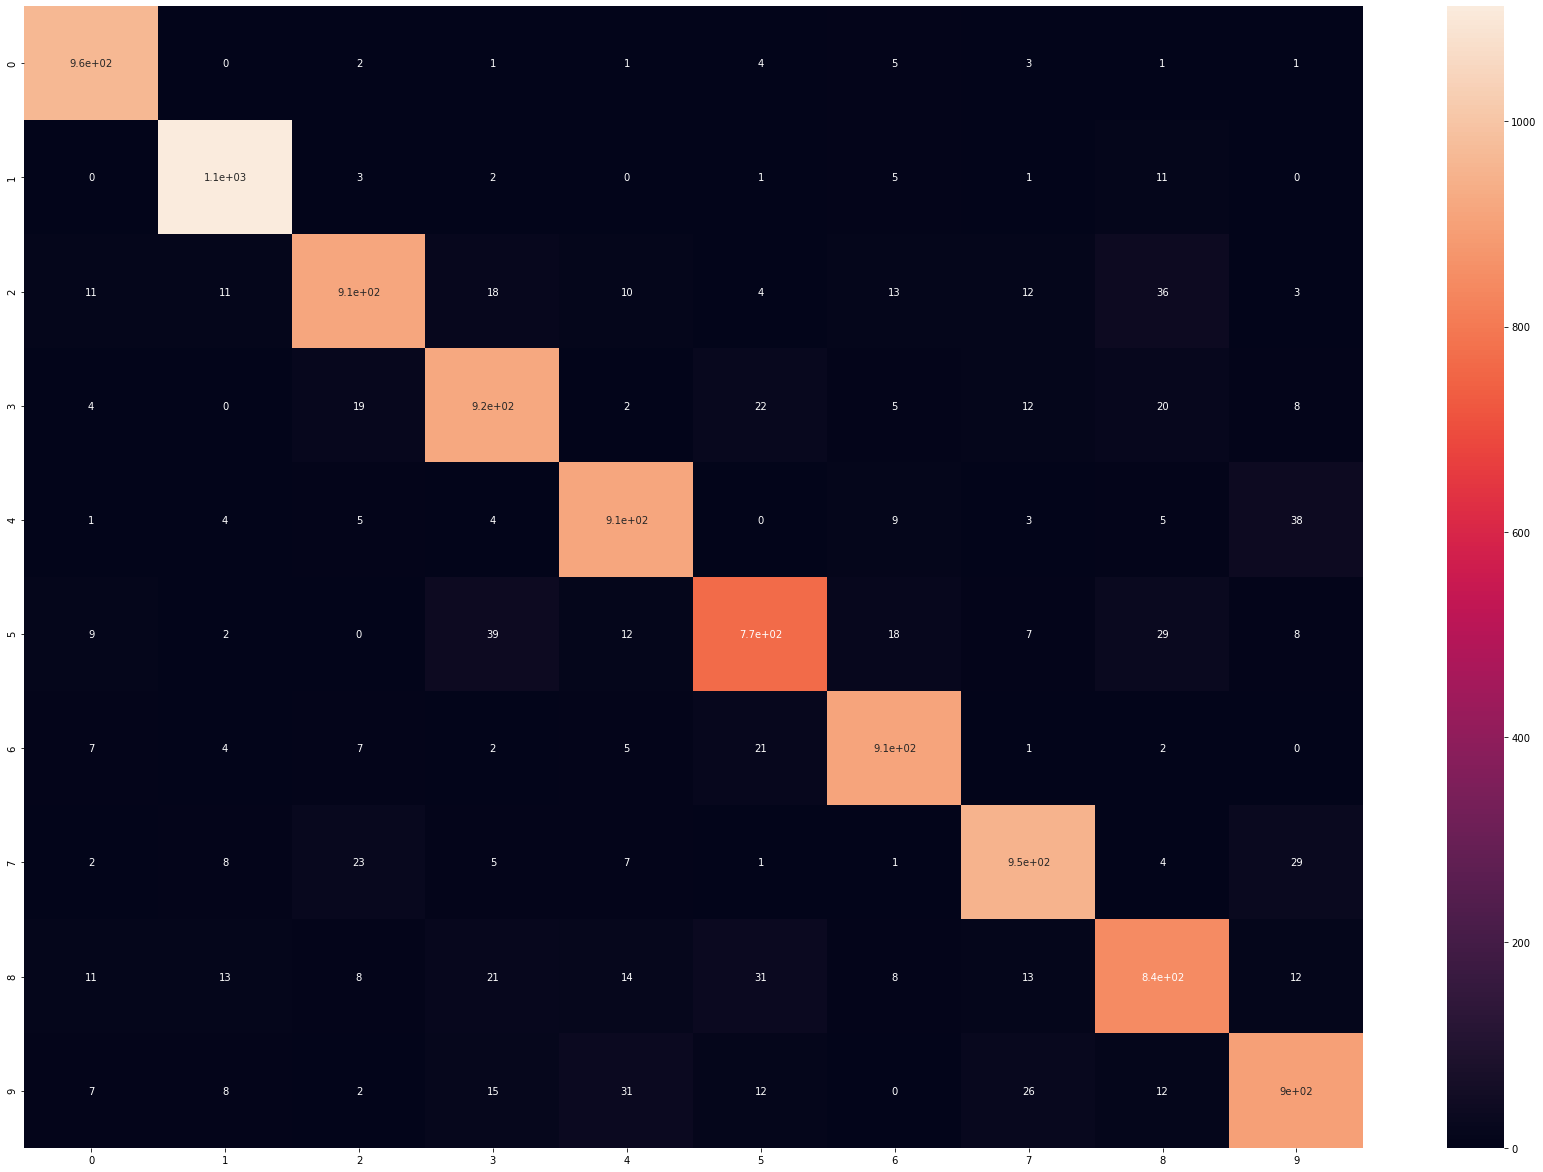

In [18]:
linsvm_predicted_ohe = np_utils.to_categorical(linsvm_digit_predicted)

create_confusion(y_test_ohe, linsvm_predicted_ohe, num_axis_labels)

One-vs-One ROC AUC scores:
0.954024 (macro), 
0.954644 (weighted)

One-vs-Rest ROC AUC scores:
0.954024 (macro), 
0.954644 (weighted)


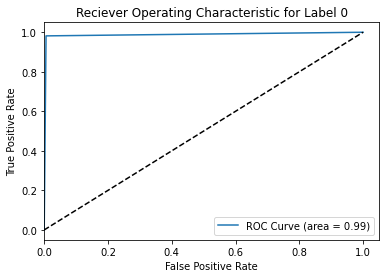

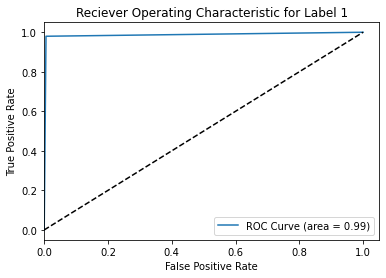

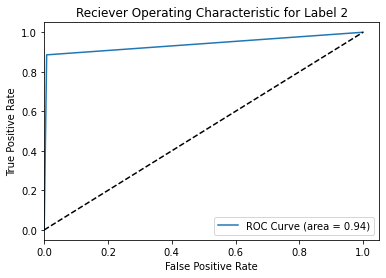

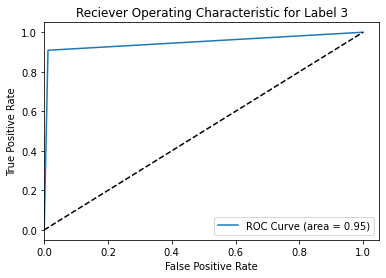

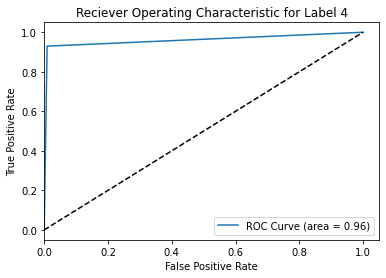

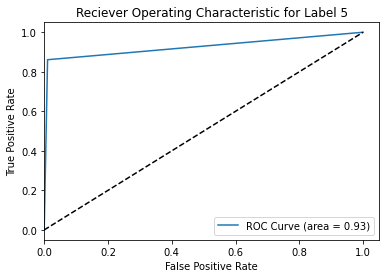

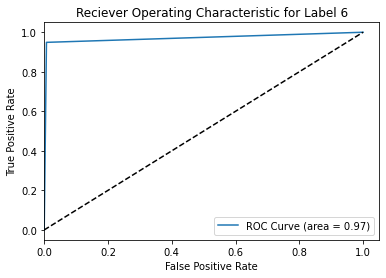

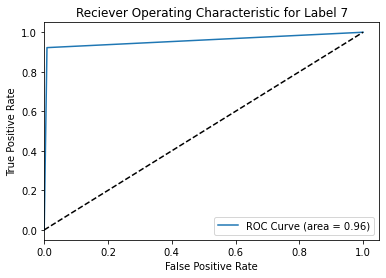

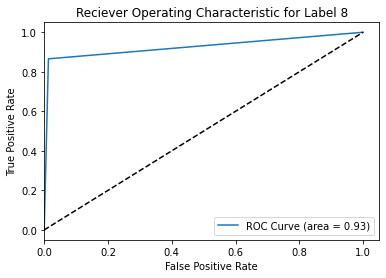

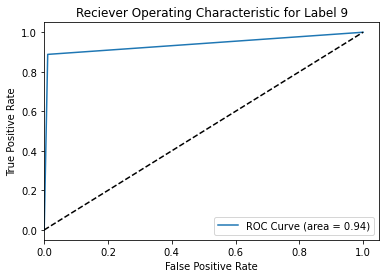

In [19]:
roc_auc(y_test_ohe, linsvm_predicted_ohe, num_classes)

## Logistic Regression with Digits

In [20]:
# Logistic Regression
logreg_digit = LogisticRegression(max_iter=1000, n_jobs=3)
logreg_digit.fit(X_train_num, y_train_num)

LogisticRegression(max_iter=1000, n_jobs=3)

In [21]:
logreg_digit_predicted = logreg_digit.predict(X_test_num)
print('Accuracy: ', accuracy_score(np.argmax(expected, axis=1), logreg_digit_predicted))

Accuracy:  0.9256


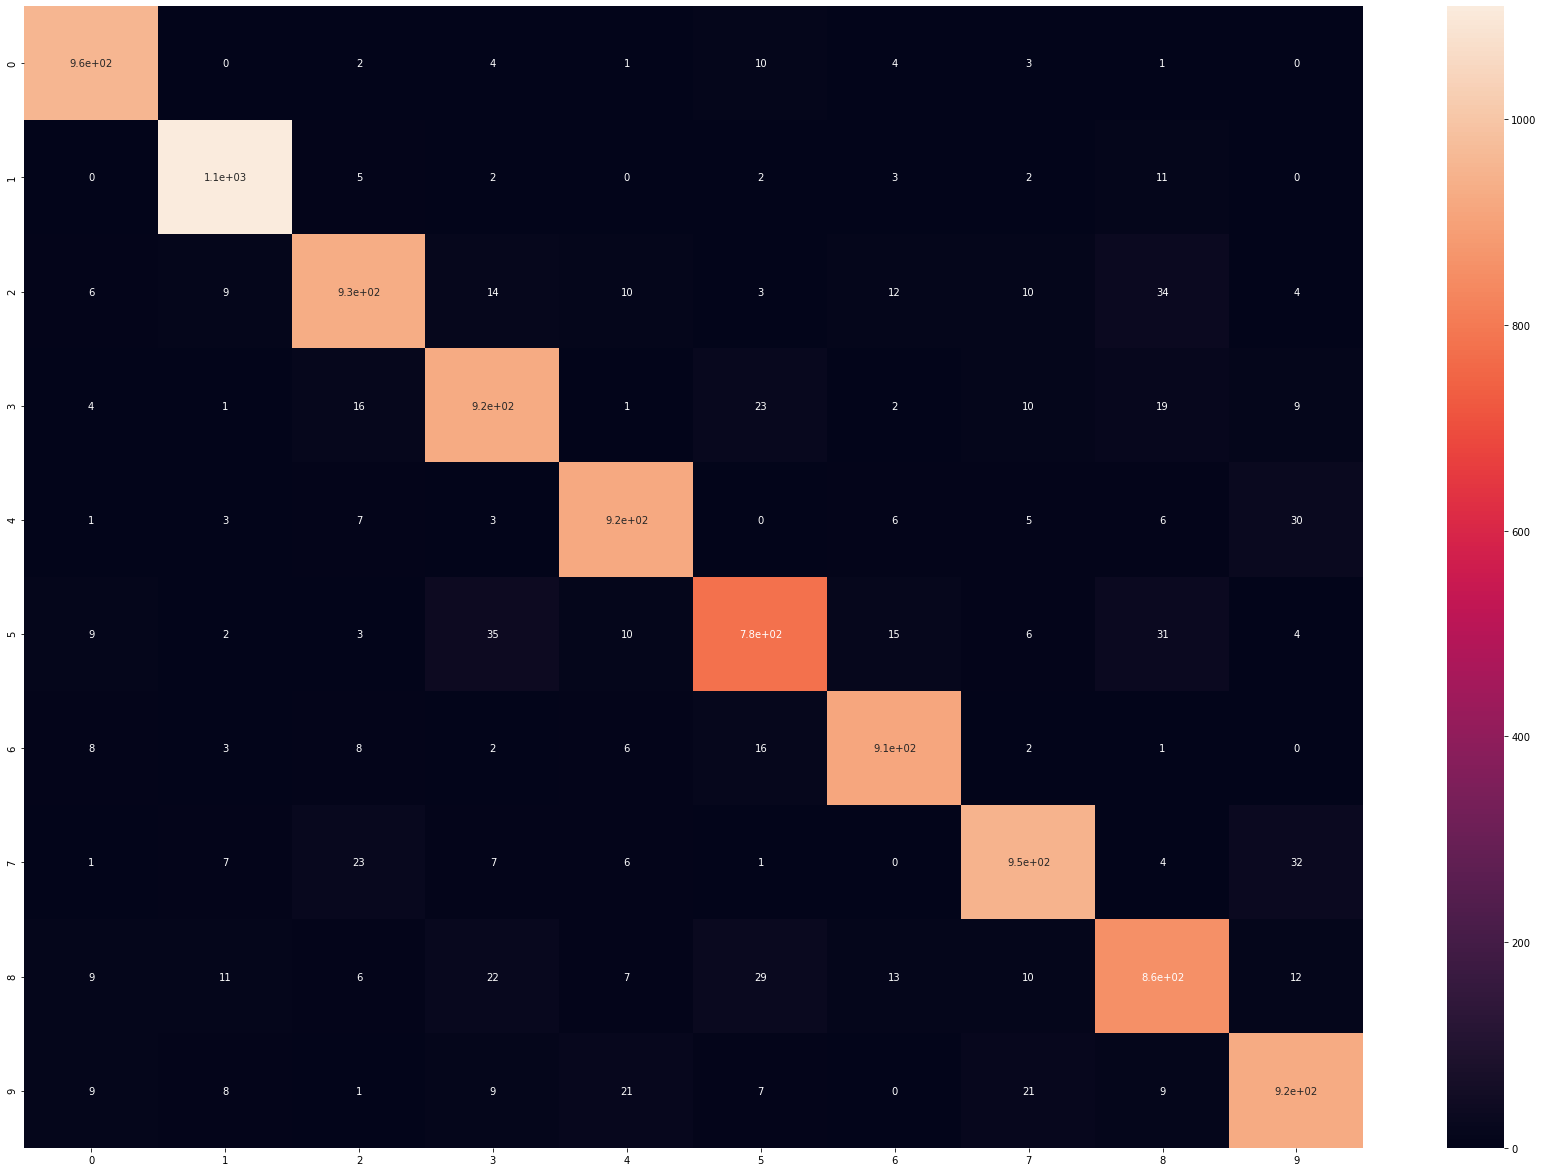

In [22]:
logreg_digit_predicted_ohe = np_utils.to_categorical(logreg_digit_predicted)

create_confusion(y_test_ohe, logreg_digit_predicted_ohe, num_axis_labels)

One-vs-One ROC AUC scores:
0.958130 (macro), 
0.958698 (weighted)

One-vs-Rest ROC AUC scores:
0.958130 (macro), 
0.958698 (weighted)


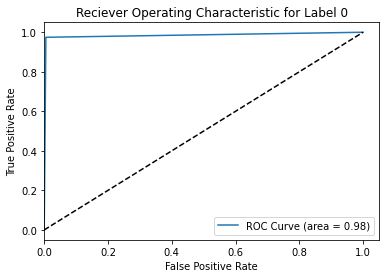

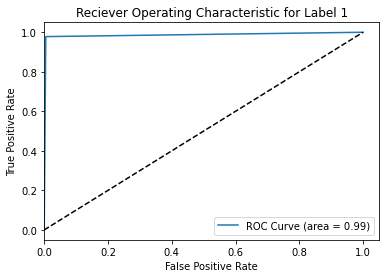

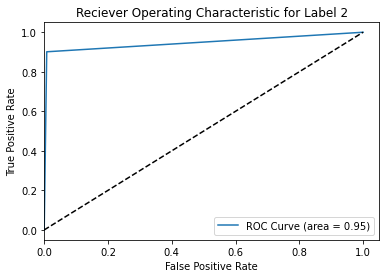

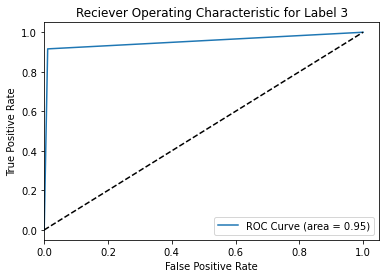

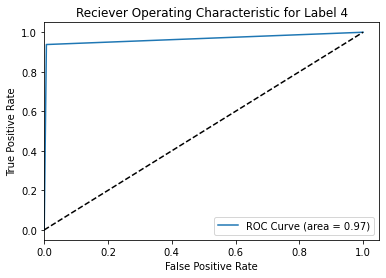

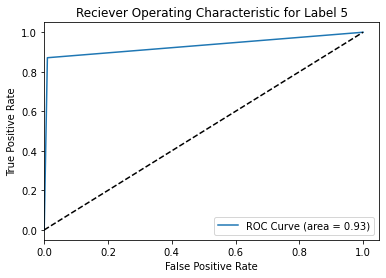

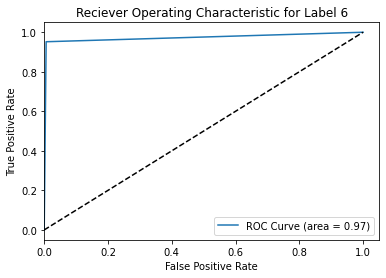

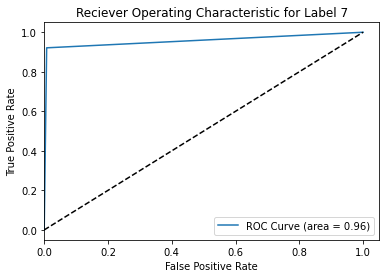

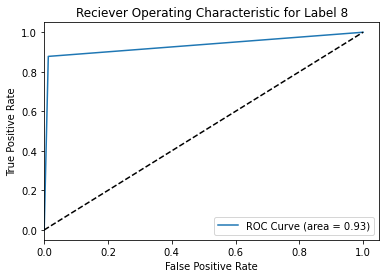

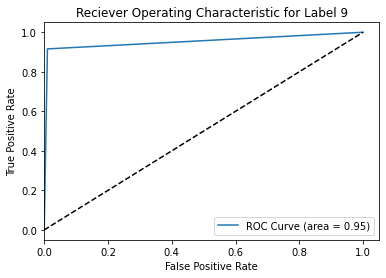

In [23]:
roc_auc(y_test_ohe, logreg_digit_predicted_ohe, num_classes)

## Simple Neural Network with Digits

In [24]:
# Simple Neural Network
def simple_nn(num_classes):
    model = Sequential()
    
    # Single hidden layer with neurons equivalent to number of pixels input
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    
    # Output Layer
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
digit_model = simple_nn(num_classes)
digit_model.fit(X_train_num, y_train_ohe, validation_data=(X_test_num, y_test_ohe), epochs=10, batch_size=200, verbose=2)

accuracy = digit_model.evaluate(X_test_num, y_test_ohe, verbose=0)
print('Accuracy: ', accuracy[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.2794 - accuracy: 0.9203 - val_loss: 0.1345 - val_accuracy: 0.9608
Epoch 2/10
 - 3s - loss: 0.1098 - accuracy: 0.9684 - val_loss: 0.0941 - val_accuracy: 0.9724
Epoch 3/10
 - 3s - loss: 0.0717 - accuracy: 0.9789 - val_loss: 0.0758 - val_accuracy: 0.9755
Epoch 4/10
 - 3s - loss: 0.0491 - accuracy: 0.9859 - val_loss: 0.0695 - val_accuracy: 0.9779
Epoch 5/10
 - 3s - loss: 0.0363 - accuracy: 0.9898 - val_loss: 0.0698 - val_accuracy: 0.9780
Epoch 6/10
 - 3s - loss: 0.0266 - accuracy: 0.9927 - val_loss: 0.0598 - val_accuracy: 0.9812
Epoch 7/10
 - 3s - loss: 0.0190 - accuracy: 0.9954 - val_loss: 0.0600 - val_accuracy: 0.9807
Epoch 8/10
 - 3s - loss: 0.0150 - accuracy: 0.9965 - val_loss: 0.0582 - val_accuracy: 0.9822
Epoch 9/10
 - 3s - loss: 0.0102 - accuracy: 0.9981 - val_loss: 0.0574 - val_accuracy: 0.9820
Epoch 10/10
 - 3s - loss: 0.0068 - accuracy: 0.9989 - val_loss: 0.0661 - val_accuracy: 0.9806
Accuracy:  0.980599

In [26]:
nn_digit_predicted = digit_model.predict(X_test_num, batch_size=200, verbose=2)
print('Accuracy: ', accuracy_score(np.argmax(expected, axis=1), np.argmax(nn_digit_predicted, axis=1)))

Accuracy:  0.9806


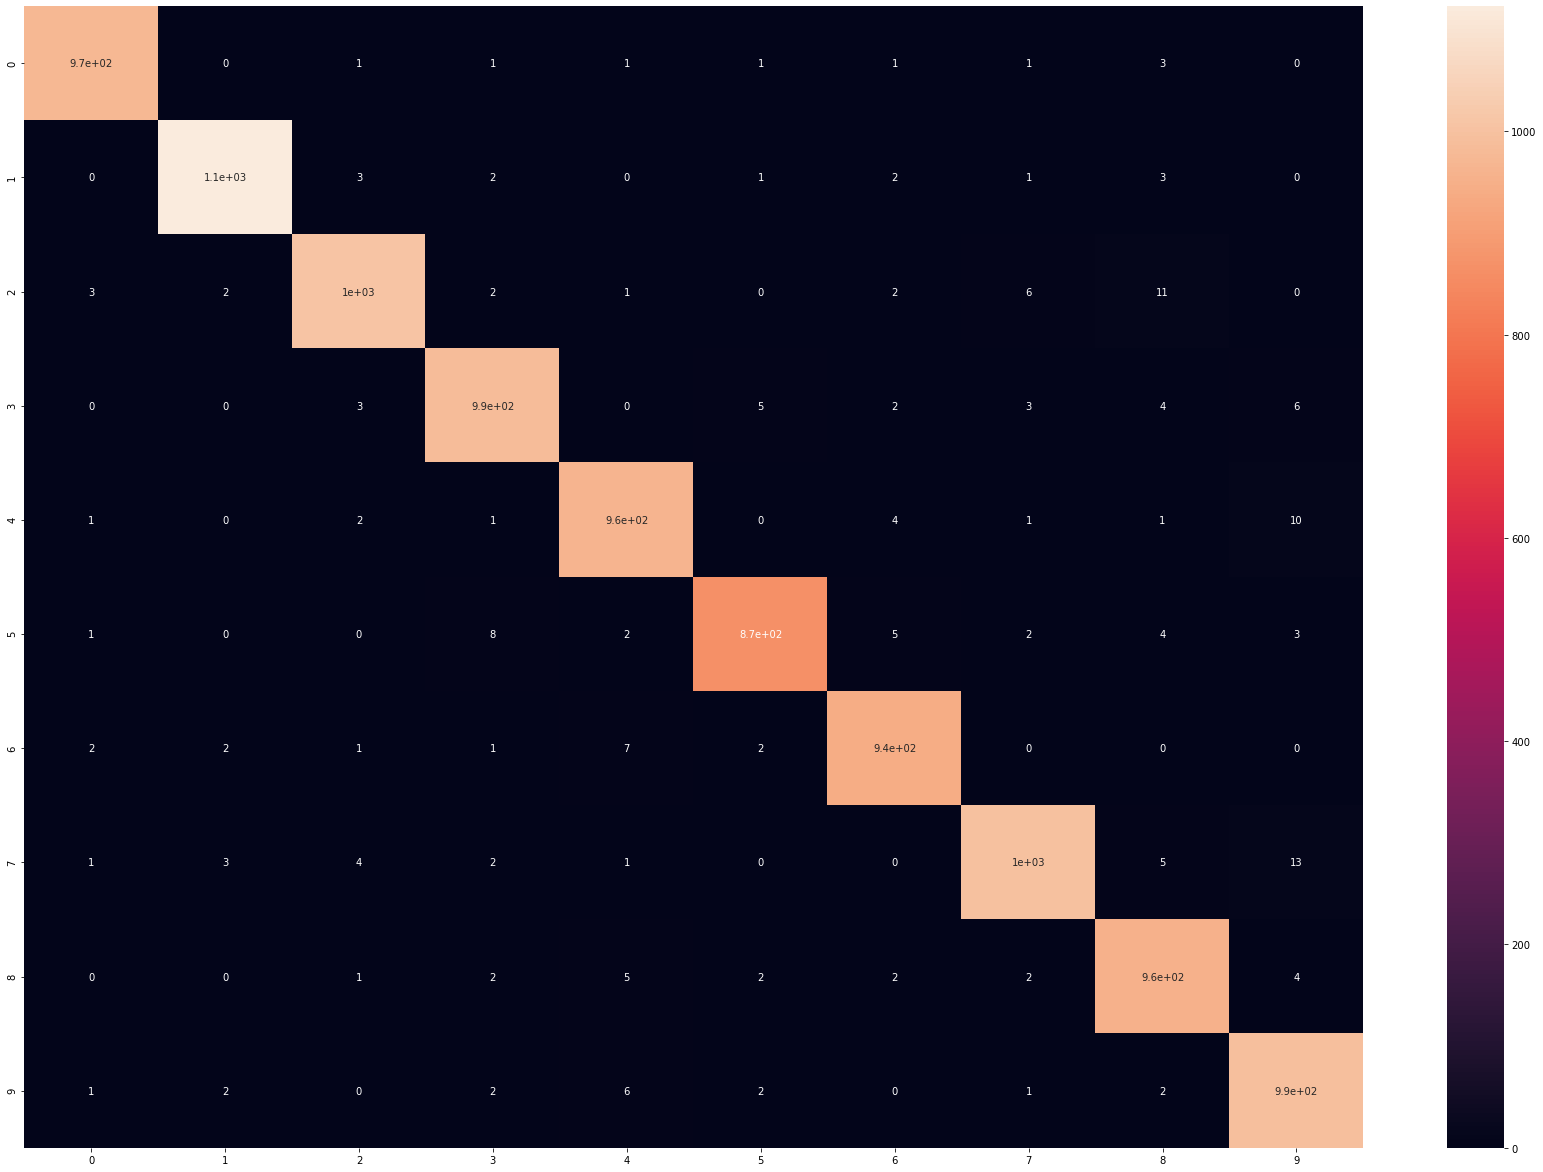

In [27]:
create_confusion(y_test_ohe, nn_digit_predicted, num_axis_labels)

One-vs-One ROC AUC scores:
0.999741 (macro), 
0.999741 (weighted)

One-vs-Rest ROC AUC scores:
0.999741 (macro), 
0.999741 (weighted)


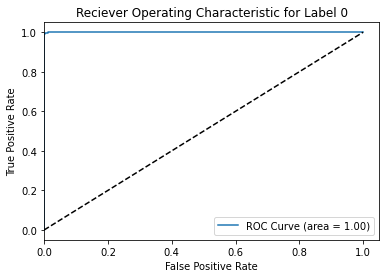

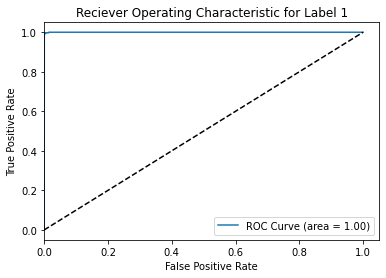

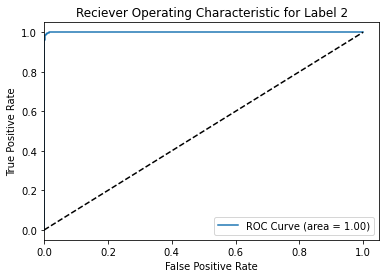

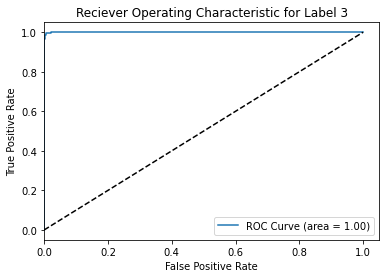

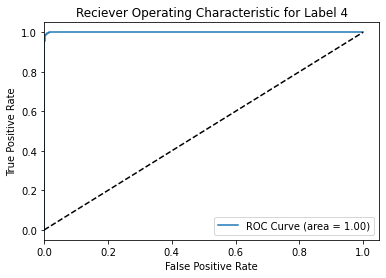

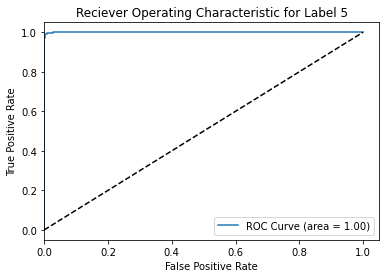

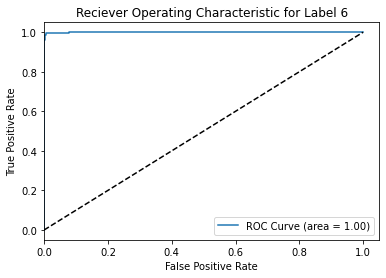

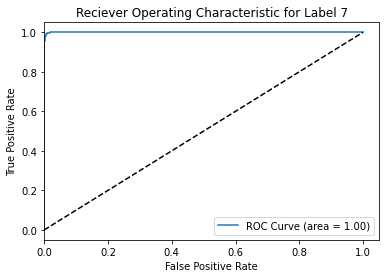

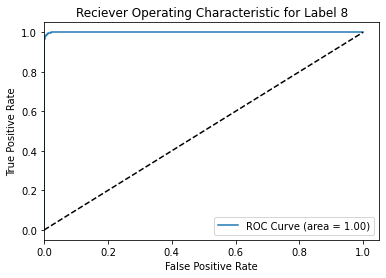

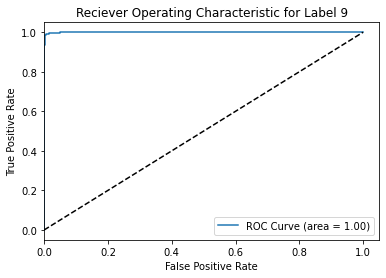

In [28]:
roc_auc(y_test_ohe, nn_digit_predicted, num_classes)

# Letter Data

In [29]:
# TODO: Test classifiers using just letter data
# Refactor roc_auc() to work with just letter data

In [30]:
letter_df = pd.read_csv('emnist-letters-train.csv')
letter_df

23  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.406  0.407  \
0       7  0    0    0    0    0    0    0    0    0  ...      0      0   
1      16  0    0    0    0    0    0    0    0    0  ...      0      0   
2      15  0    0    0    0    0    0    0    0    0  ...      0      0   
3      23  0    0    0    0    0    0    0    0    0  ...      0      0   
4      17  0    0    0    0    0    0    0    0    0  ...      0      0   
...    .. ..  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
88794   1  0    0    0    0    0    0    0    0    0  ...      0      0   
88795  21  0    0    0    0    0    0    0    0    0  ...      0      0   
88796   1  0    0    0    0    0    0    0    0    0  ...      0      0   
88797  23  0    0    0    0    0    0    0    0    0  ...      0      0   
88798  12  0    0    0    0    0    0    0    0    0  ...      0      0   

       0.408  0.409  0.410  0.411  0.412  0.413  0.414  0.415  
0          0      0      0      0      0      0      0      0  
1          0      0      0      0      0      0      0      0  
2          0      0      0      0      0      0      0      0  
3          0      0      0      0      0      0      0      0  
4          0      0      0      0      0      0      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...  
88794      0      0      0      0      0      0      0      0  
88795      0      0      0      0      0      0      0      0  
88796      0      0      0      0      0      0      0      0  
88797      0      0      0      0      0      0      0      0  
88798      0      0      0      0      0      0      0      0  

[88799 rows x 785 columns]

In [31]:
letter_df = letter_df.rename(columns={'23': 'Label'})
a = letter_df.columns[np.arange(1, 785)]
b = [i for i in range(len(a))]
d = dict(zip(a, b))
letter_df = letter_df.rename(columns=d)
letter_df

Label  0  1  2  3  4  5  6  7  8  ...  774  775  776  777  778  779  \
0          7  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
1         16  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
2         15  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
3         23  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
4         17  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
...      ... .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...   
88794      1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88795     21  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88796      1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88797     23  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88798     12  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   

       780  781  782  783  
0        0    0    0    0  
1        0    0    0    0  
2        0    0    0    0  
3        0    0    0    0  
4        0    0    0    0  
...    ...  ...  ...  ...  
88794    0    0    0    0  
88795    0    0    0    0  
88796    0    0    0    0  
88797    0    0    0    0  
88798    0    0    0    0  

[88799 rows x 785 columns]

In [32]:
np.unique(letter_df['Label'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64)

In [33]:
letter_df['Label'] = letter_df['Label'] - 1

np.unique(letter_df['Label'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)

In [34]:
y_letter = letter_df['Label']
X_letter = letter_df.drop(['Label'], axis=1)

y_letter

0         6
1        15
2        14
3        22
4        16
         ..
88794     0
88795    20
88796     0
88797    22
88798    11
Name: Label, Length: 88799, dtype: int64

In [35]:
X_letter

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
88794    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88795    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88796    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88797    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88798    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

       777  778  779  780  781  782  783  
0        0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
88794    0    0    0    0    0    0    0  
88795    0    0    0    0    0    0    0  
88796    0    0    0    0    0    0    0  
88797    0    0    0    0    0    0    0  
88798    0    0    0    0    0    0    0  

[88799 rows x 784 columns]

In [36]:
from sklearn.model_selection import train_test_split
X_train_letter, X_test_letter, y_train_letter, y_test_letter = train_test_split(X_letter, y_letter, test_size=.33)

X_train_letter

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
7190     0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
76689    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
49183    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
39730    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
34312    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
26924    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
55865    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
76197    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
71571    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
76066    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

       777  778  779  780  781  782  783  
7190     0    0    0    0    0    0    0  
76689    0    0    0    0    0    0    0  
49183    0    0    0    0    0    0    0  
39730    0    0    0    0    0    0    0  
34312    0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
26924    0    0    0    0    0    0    0  
55865    0    0    0    0    0    0    0  
76197    0    0    0    0    0    0    0  
71571    0    0    0    0    0    0    0  
76066    0    0    0    0    0    0    0  

[59495 rows x 784 columns]

In [37]:
y_train_letter

7190     16
76689    20
49183     3
39730    21
34312     1
         ..
26924    20
55865    21
76197     2
71571    10
76066    21
Name: Label, Length: 59495, dtype: int64

In [38]:
X_test_letter

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
22662    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
86434    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
68026    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
72092    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
60536    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
78773    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
76808    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
63786    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
30582    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
79099    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

       777  778  779  780  781  782  783  
22662    0    0    0    0    0    0    0  
86434    0    0    0    0    0    0    0  
68026    0    0    0    0    0    0    0  
72092    0    0    0    0    0    0    0  
60536    0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
78773    0    0    0    0    0    0    0  
76808    0    0    0    0    0    0    0  
63786    0    0    0    0    0    0    0  
30582    0    0    0    0    0    0    0  
79099    0    0    0    0    0    0    0  

[29304 rows x 784 columns]

In [39]:
y_test_letter

22662    21
86434    22
68026    21
72092    15
60536     1
         ..
78773     0
76808     9
63786     8
30582     0
79099    25
Name: Label, Length: 29304, dtype: int64

In [40]:
X_train_letter = np.array(X_train_letter.iloc[:, 0:].values)
y_train_letter = np.array(y_train_letter)

X_test_letter = np.array(X_test_letter.iloc[:, 0:].values)
y_test_letter = np.array(y_test_letter)

X_train_letter = X_train_letter / 255
X_test_letter = X_test_letter / 255

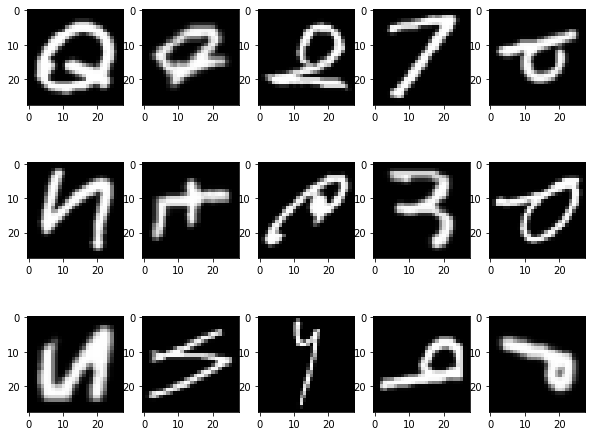

In [41]:
fig, axes = plt.subplots(3, 5, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_letter[i].reshape([28,28]), cmap=plt.get_cmap('gray'))

In [42]:
num_classes = 26
y_train_letter_ohe = np_utils.to_categorical(y_train_letter, num_classes)
y_test_letter_ohe = np_utils.to_categorical(y_test_letter, num_classes)

In [43]:
y_test_letter_ohe.shape

(29304, 26)

## K-Nearest Neighbors with Letters

In [44]:
knn_letter = KNeighborsClassifier(n_jobs=3)
knn_letter.fit(X_train_letter, y_train_letter_ohe)

KNeighborsClassifier(n_jobs=3)

In [45]:
knn_letter_predicted = knn_letter.predict(X_test_letter)

In [46]:
print('Accuracy: ', accuracy_score(y_test_letter_ohe, knn_letter_predicted))

Accuracy:  0.8155541905541905


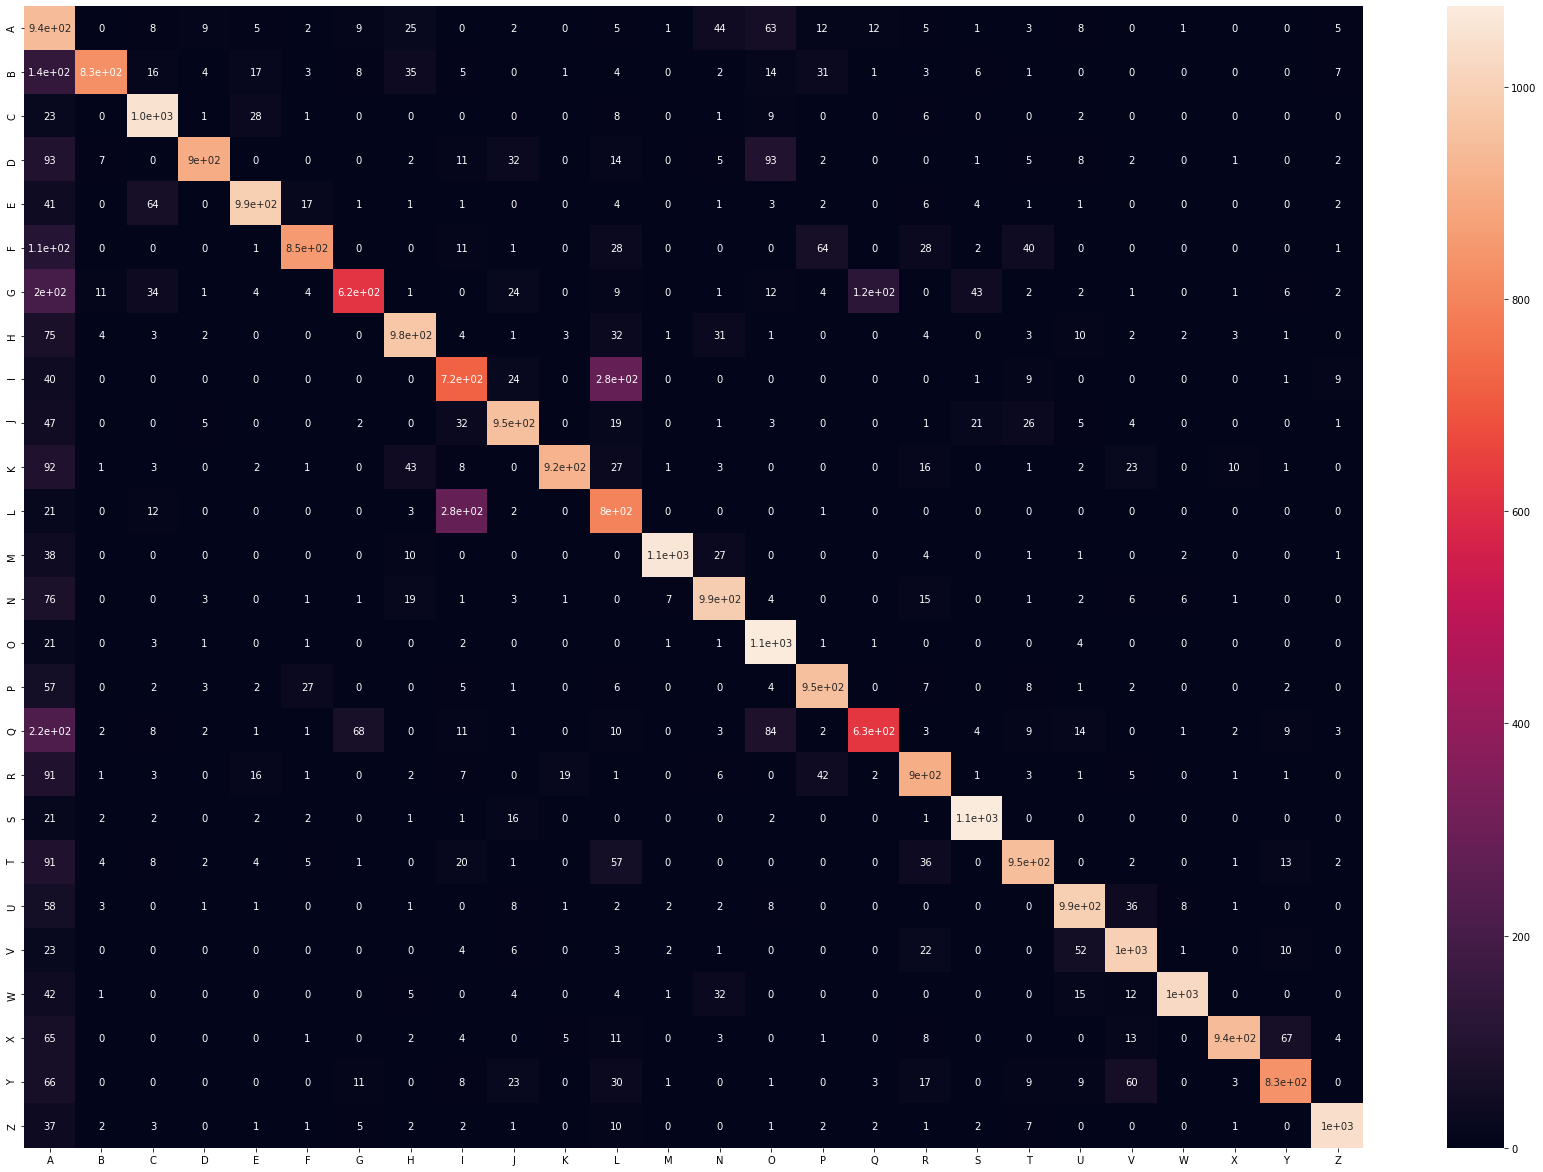

In [47]:
letter_axis_labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

create_confusion(y_test_letter_ohe, knn_letter_predicted, letter_axis_labels)

In [48]:
## TODO: roc-auc after refactor

## Logistic Regression with Letters

In [49]:
logreg_letter = LogisticRegression(max_iter=10000, n_jobs=3)
logreg_letter.fit(X_train_letter, y_train_letter)

LogisticRegression(max_iter=10000, n_jobs=3)

In [50]:
logreg_letter_predicted = logreg_letter.predict(X_test_letter)
print('Accuracy: ', accuracy_score(y_test_letter, logreg_letter_predicted))

Accuracy:  0.7035558285558285


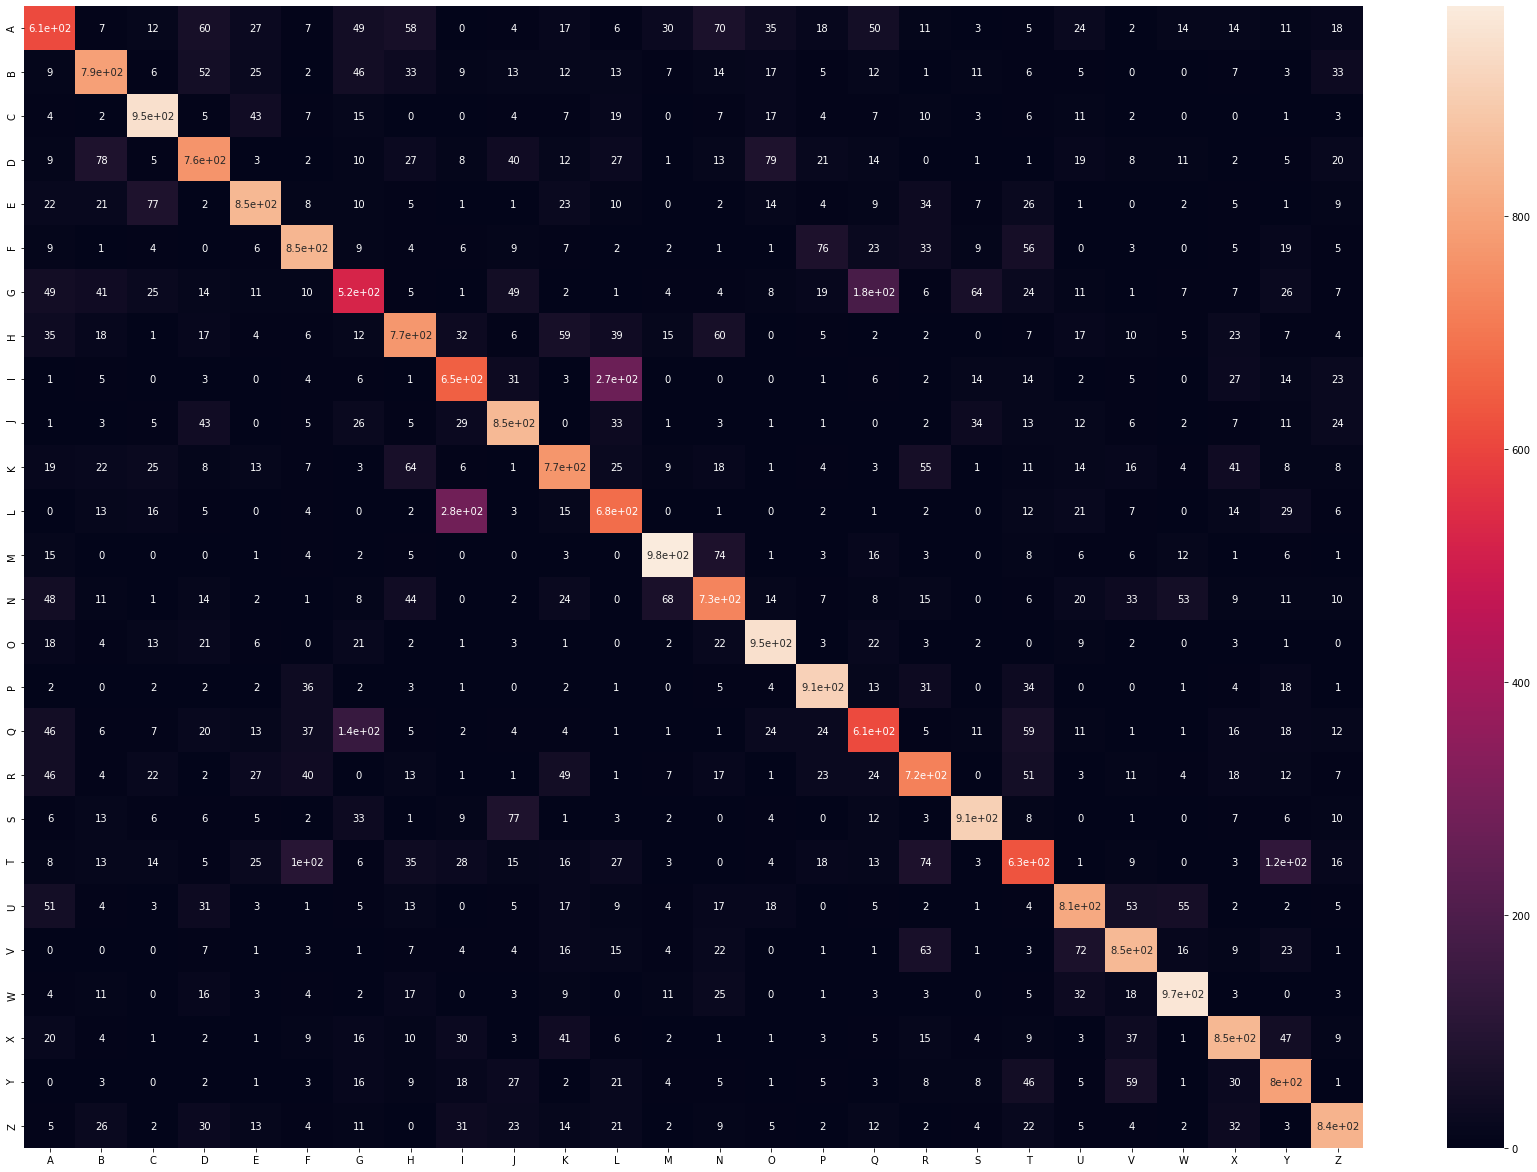

In [51]:
logreg_letter_predicted_ohe = np_utils.to_categorical(logreg_letter_predicted)

create_confusion(y_test_letter_ohe, logreg_letter_predicted_ohe, letter_axis_labels)

## Simple Neural Network with Letters

In [52]:
letter_model = simple_nn(num_classes)
letter_model.fit(X_train_letter, y_train_letter_ohe, validation_data=(X_test_letter, y_test_letter_ohe), 
          epochs=10, batch_size=200, verbose=2)

accuracy = letter_model.evaluate(X_test_letter, y_test_letter_ohe, verbose=0)
print('Accuracy: ', accuracy[1])

Train on 59495 samples, validate on 29304 samples
Epoch 1/10
 - 4s - loss: 0.9463 - accuracy: 0.7278 - val_loss: 0.6026 - val_accuracy: 0.8222
Epoch 2/10
 - 4s - loss: 0.4813 - accuracy: 0.8560 - val_loss: 0.4635 - val_accuracy: 0.8594
Epoch 3/10
 - 4s - loss: 0.3606 - accuracy: 0.8895 - val_loss: 0.4097 - val_accuracy: 0.8728
Epoch 4/10
 - 4s - loss: 0.2949 - accuracy: 0.9085 - val_loss: 0.3594 - val_accuracy: 0.8869
Epoch 5/10
 - 4s - loss: 0.2512 - accuracy: 0.9201 - val_loss: 0.3524 - val_accuracy: 0.8899
Epoch 6/10
 - 4s - loss: 0.2199 - accuracy: 0.9290 - val_loss: 0.3415 - val_accuracy: 0.8926
Epoch 7/10
 - 4s - loss: 0.1915 - accuracy: 0.9373 - val_loss: 0.3346 - val_accuracy: 0.8960
Epoch 8/10
 - 5s - loss: 0.1713 - accuracy: 0.9433 - val_loss: 0.3377 - val_accuracy: 0.8957
Epoch 9/10
 - 4s - loss: 0.1517 - accuracy: 0.9495 - val_loss: 0.3424 - val_accuracy: 0.8938
Epoch 10/10
 - 4s - loss: 0.1369 - accuracy: 0.9541 - val_loss: 0.3405 - val_accuracy: 0.8939
Accuracy:  0.893905

In [53]:
nn_letter_predicted = letter_model.predict(X_test_letter, batch_size=200, verbose=2)
print('Accuracy: ', accuracy_score(y_test_letter, np.argmax(nn_letter_predicted, axis=1)))

Accuracy:  0.8939052689052689


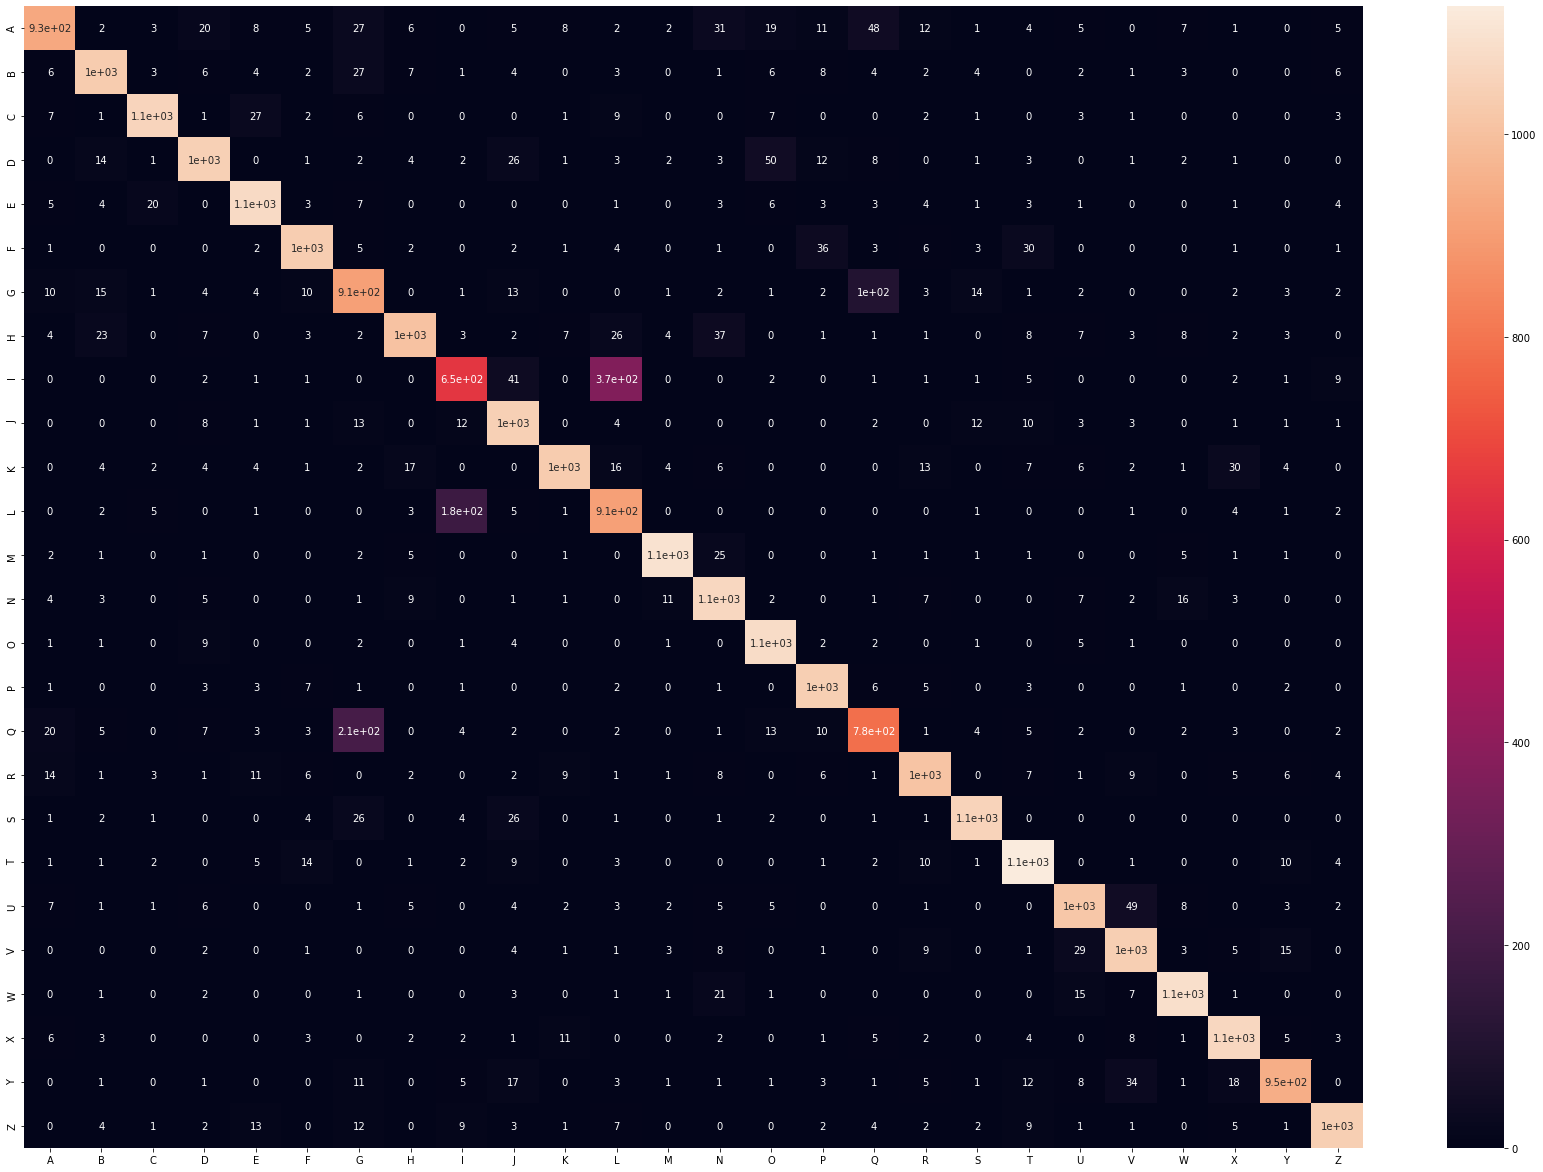

In [54]:
create_confusion(y_test_letter_ohe, nn_letter_predicted, letter_axis_labels)

# Letter and Digit Data

In [55]:
X_train_num = X_train_num * 255
letter_df['Label'] = letter_df['Label'] + 10

#np.unique(letter_df['Label'])
num_df = pd.DataFrame(X_train_num)
num_df['Label'] = y_train_num
first_col = num_df.pop('Label')
num_df.insert(0, 'Label', first_col)
num_df

Label    0    1    2    3    4    5    6    7    8  ...  774  775  776  \
0          5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2          4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3          1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4          9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59995      8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59996      3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59997      5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59998      6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59999      8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
59995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[60000 rows x 785 columns]

In [56]:
df = pd.concat([num_df, letter_df])
df

Label    0    1    2    3    4    5    6    7    8  ...  774  775  776  \
0          5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2          4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3          1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4          9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
88794     10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88795     30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88796     10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88797     32  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88798     21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
88794  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88795  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88796  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88797  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88798  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[148799 rows x 785 columns]

In [57]:
y = df.pop('Label')
X = df

X

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
88794  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88795  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88796  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88797  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88798  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
88794  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88795  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88796  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88797  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88798  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[148799 rows x 784 columns]

In [58]:
y

0         5
1         0
2         4
3         1
4         9
         ..
88794    10
88795    30
88796    10
88797    32
88798    21
Name: Label, Length: 148799, dtype: int64

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

X_train

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
75270  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9487   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
27470  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
18776  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
21817  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19658  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
11703  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26282  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
19583  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
15553  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
75270  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9487   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
27470  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
18776  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
21817  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
19658  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
11703  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
26282  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
19583  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
15553  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[99695 rows x 784 columns]

In [60]:
y_train

75270    15
9487     20
27470    32
18776     2
21817    35
         ..
19658     7
11703    17
26282    19
19583     0
15553     9
Name: Label, Length: 99695, dtype: int64

In [61]:
X_test

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
48996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
47736  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
17410  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
37759  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
30442  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
40600  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
43042  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
66337  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6957   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2457   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
48996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
47736  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
17410  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
37759  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
30442  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
40600  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
43042  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
66337  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
6957   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2457   0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[49104 rows x 784 columns]

In [62]:
y_test

48996    32
47736     0
17410    32
37759     0
30442     7
         ..
40600    21
43042     8
66337    20
6957      8
2457      2
Name: Label, Length: 49104, dtype: int64

In [63]:
X_train = np.array(X_train.iloc[:, 0:].values)
y_train = np.array(y_train)

X_test = np.array(X_test.iloc[:, 0:].values)
y_test = np.array(y_test)

X_train /= 255
X_test /= 255

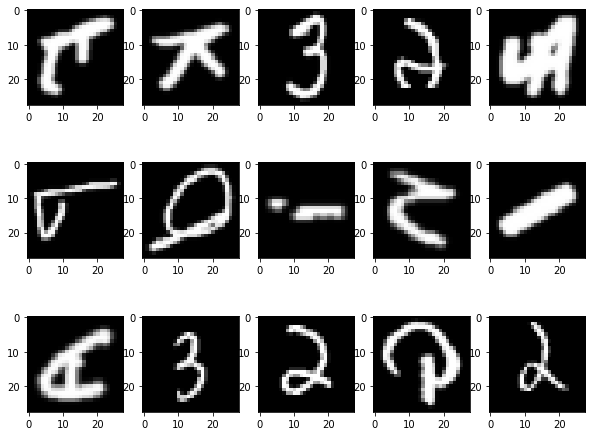

In [64]:
fig, axes = plt.subplots(3, 5, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28,28]), cmap=plt.get_cmap('gray'))

In [65]:
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

num_classes = y_test_ohe.shape[1]
num_classes

36

## K-Nearest Neighbors

In [66]:
knn = KNeighborsClassifier(n_jobs=3)
knn.fit(X_train, y_train_ohe)

KNeighborsClassifier(n_jobs=3)

In [67]:
knn_predicted = knn.predict(X_test)

In [68]:
print('Accuracy: ', accuracy_score(y_test_ohe, knn_predicted))

Accuracy:  0.8653673835125448


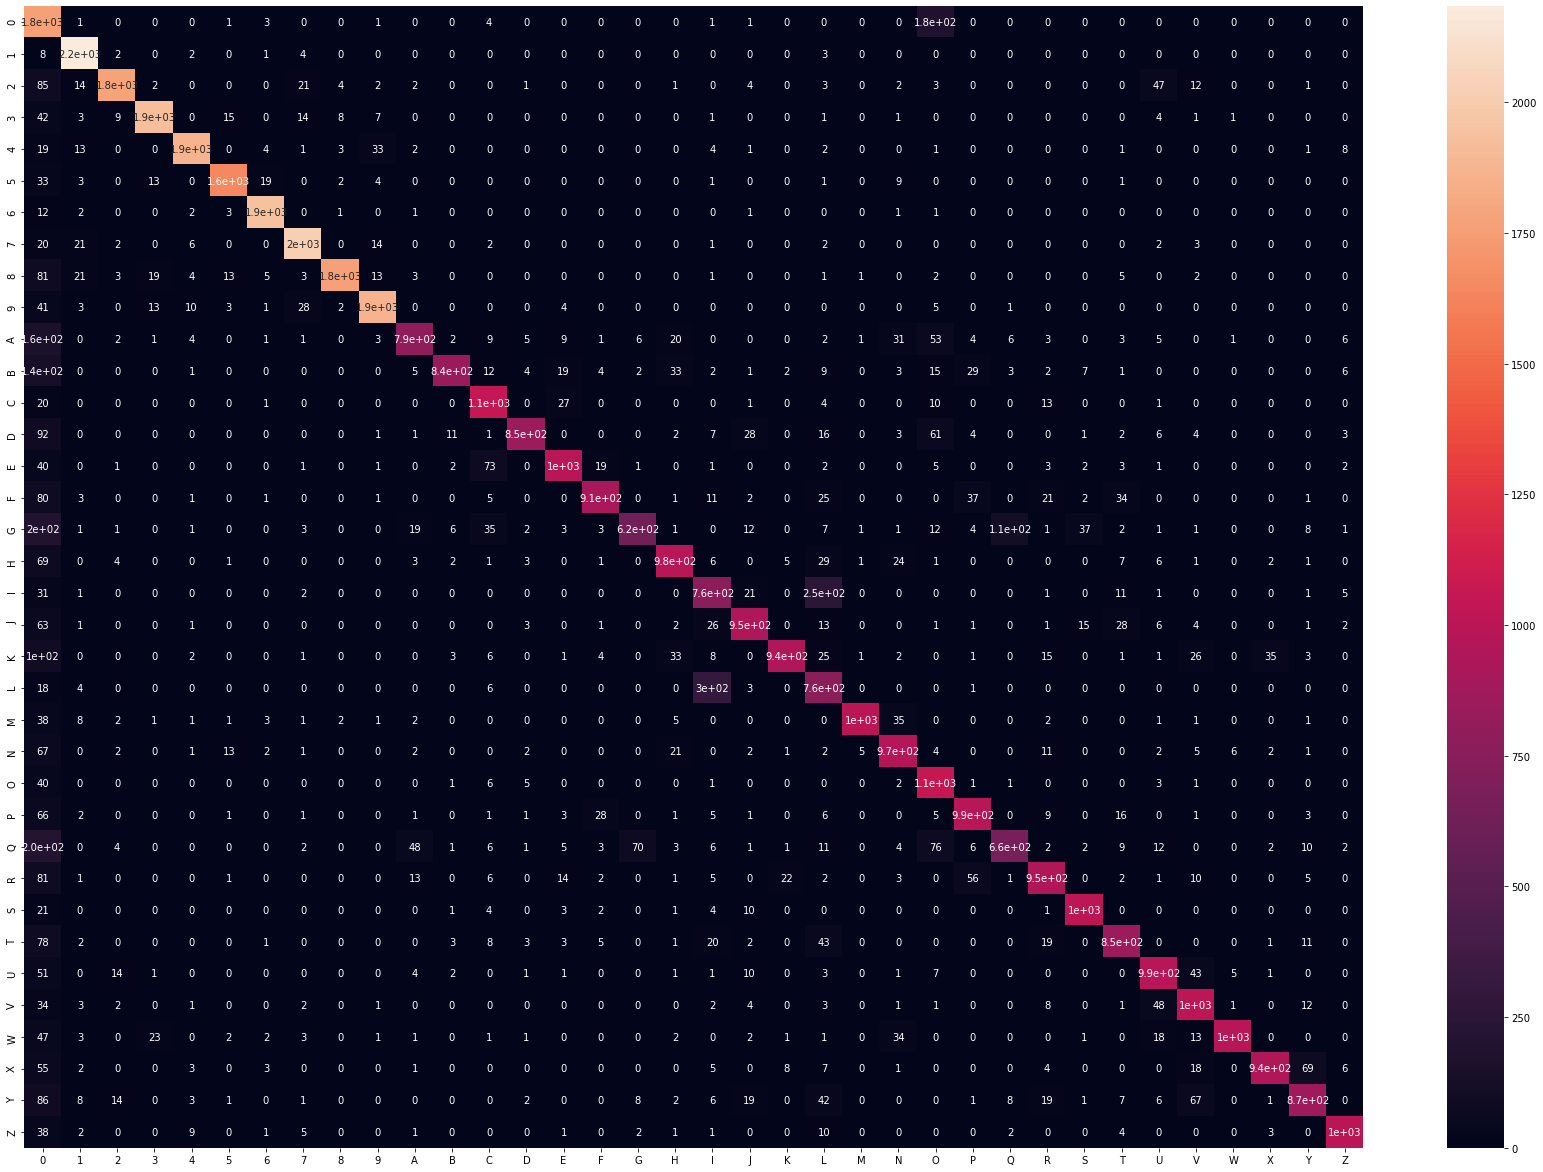

In [69]:
axis_labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

create_confusion(y_test_ohe, knn_predicted, axis_labels)

#letter_df

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.923138 (macro), 
0.931510 (weighted)

One-vs-Rest ROC AUC scores:
0.923138 (macro), 
0.931510 (weighted)


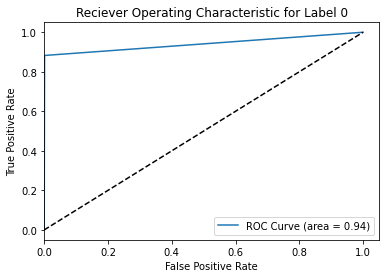

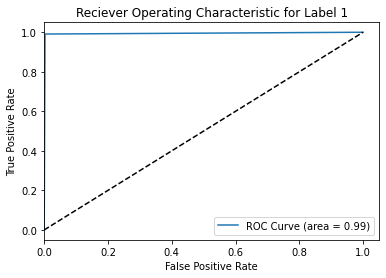

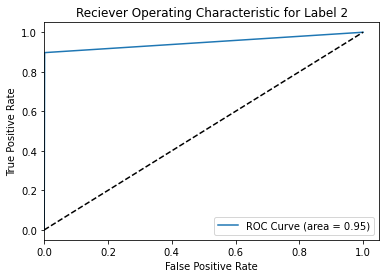

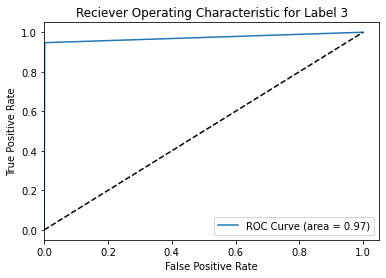

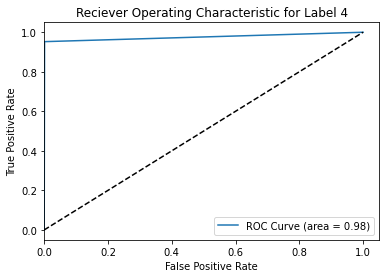

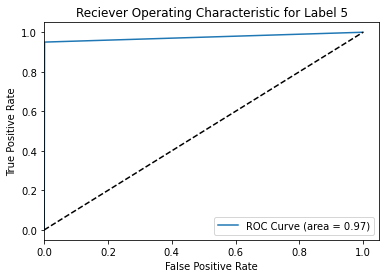

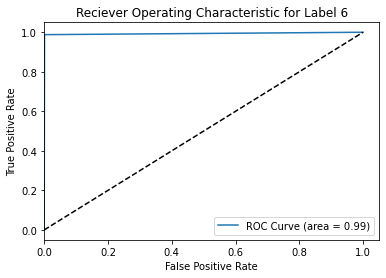

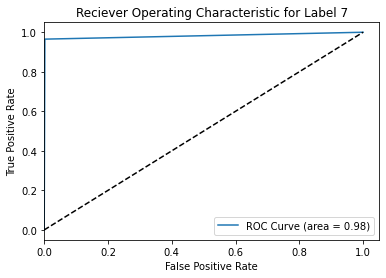

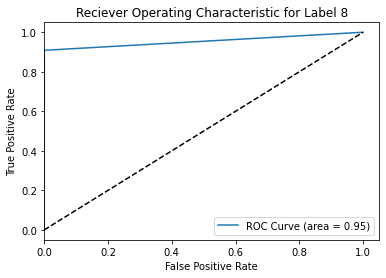

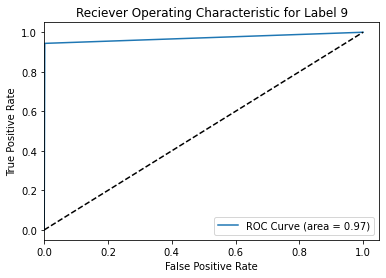

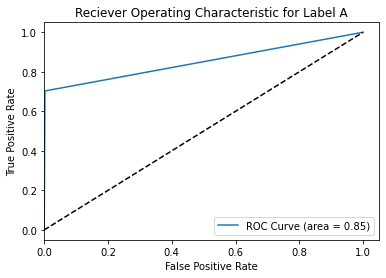

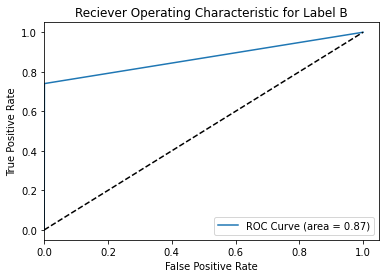

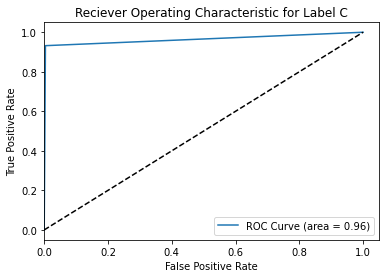

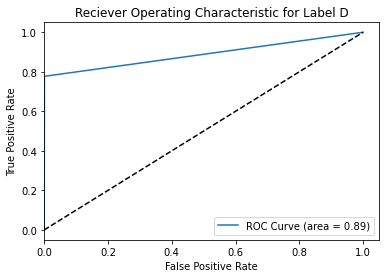

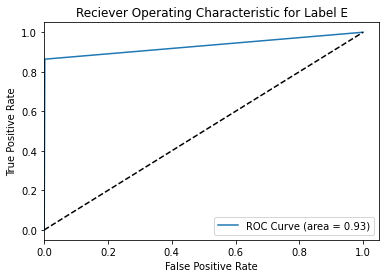

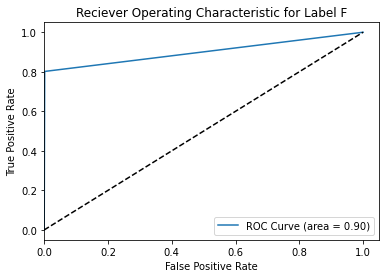

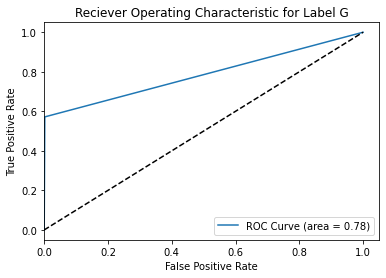

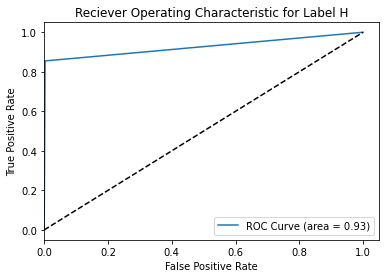

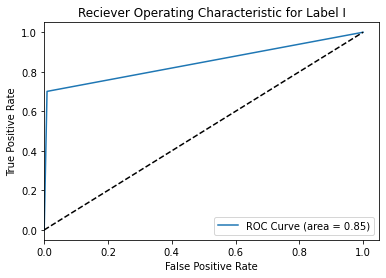

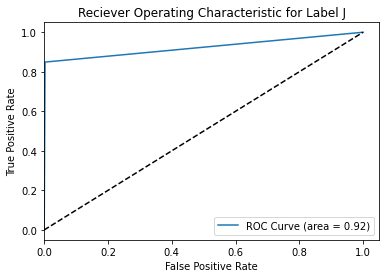

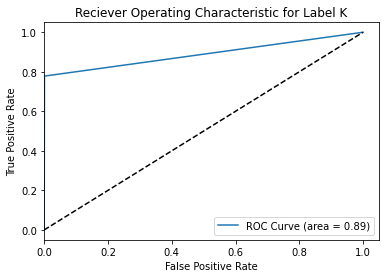

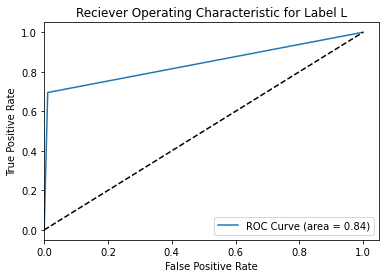

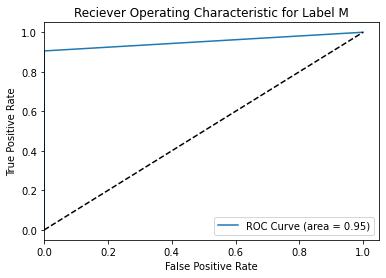

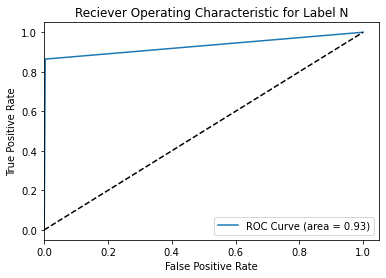

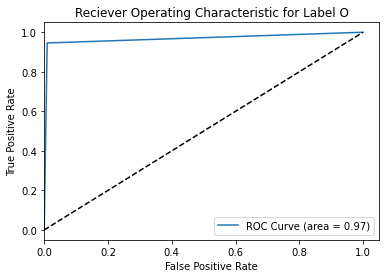

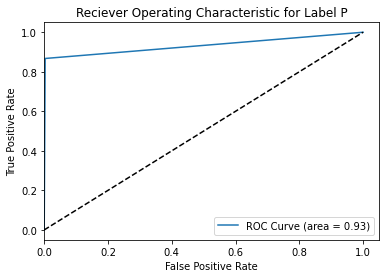

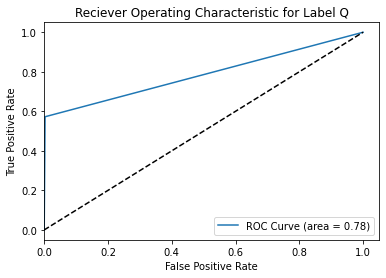

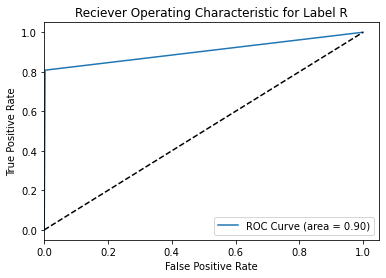

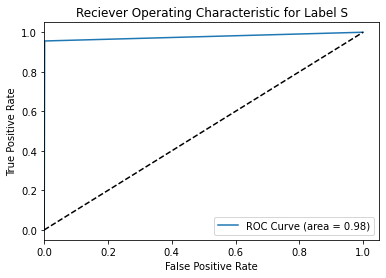

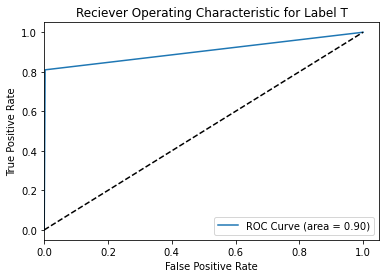

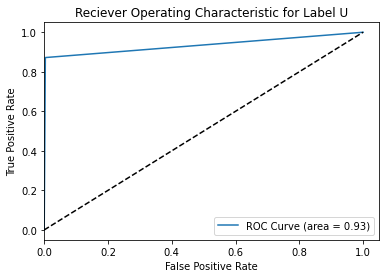

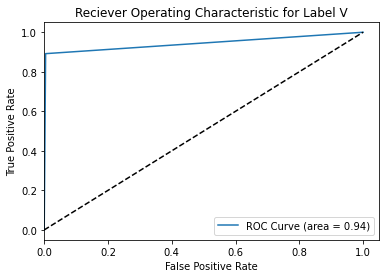

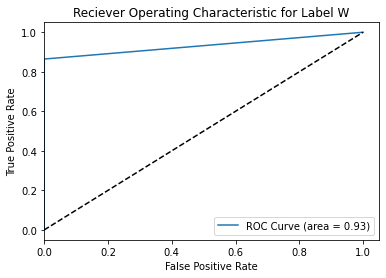

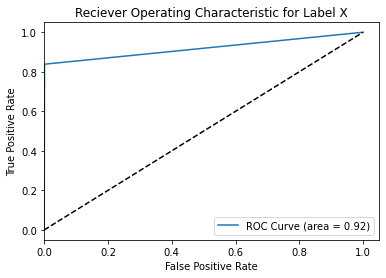

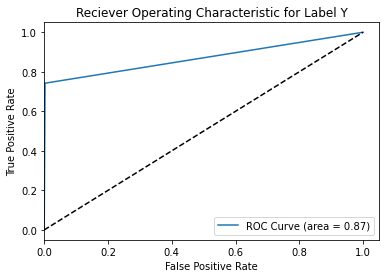

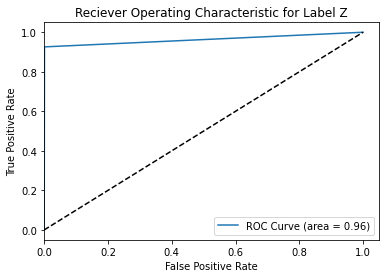

In [70]:
roc_auc(y_test_ohe, knn_predicted, num_classes)

## Logistic Regression

In [71]:
logreg = LogisticRegression(max_iter=10000, n_jobs=3)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=3)

In [72]:
logreg_predicted = logreg.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, logreg_predicted))

Accuracy:  0.7772890192245031


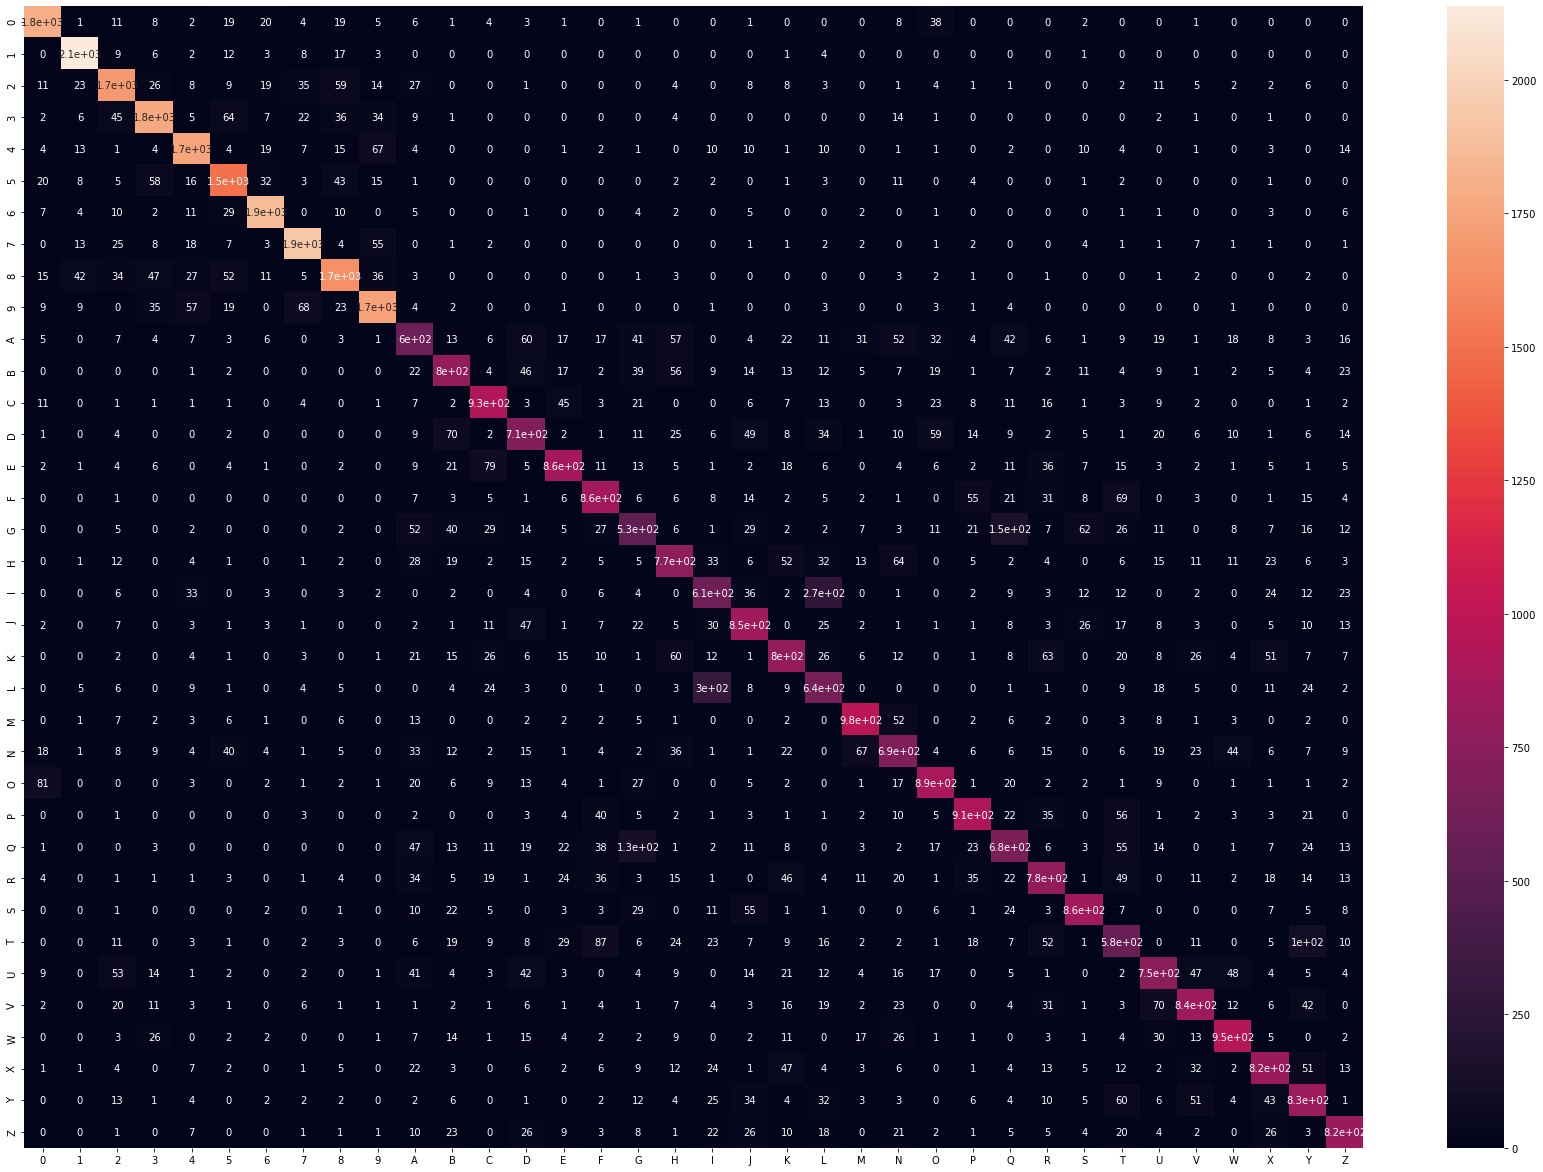

In [73]:
logreg_predicted_ohe = np_utils.to_categorical(logreg_predicted)

create_confusion(y_test_ohe, logreg_predicted_ohe, axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.872200 (macro), 
0.885609 (weighted)

One-vs-Rest ROC AUC scores:
0.872200 (macro), 
0.885609 (weighted)


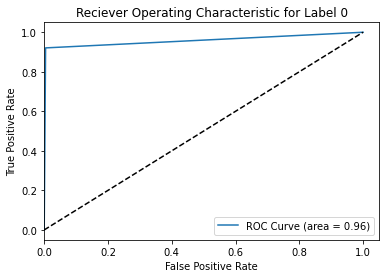

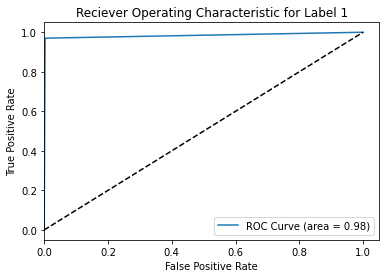

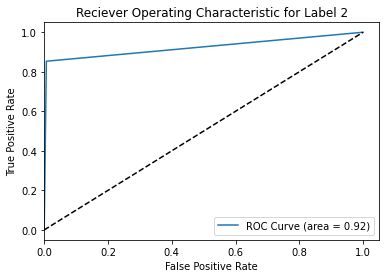

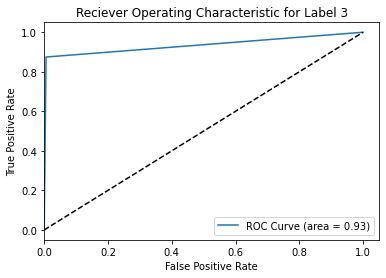

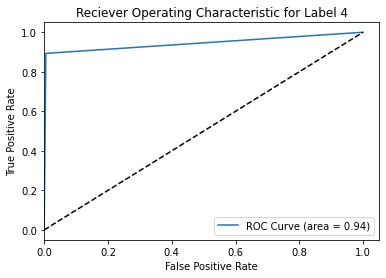

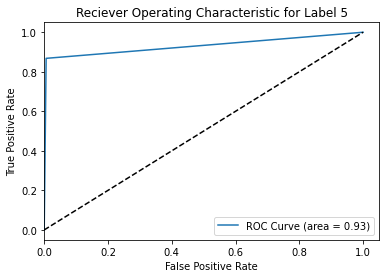

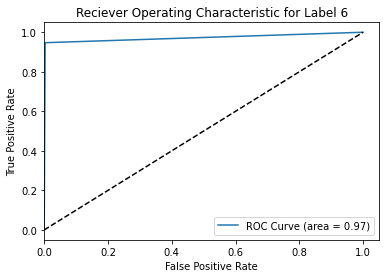

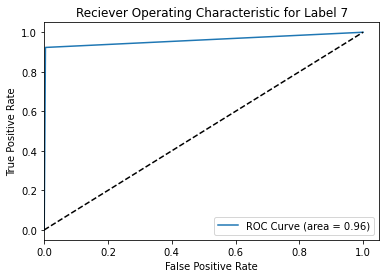

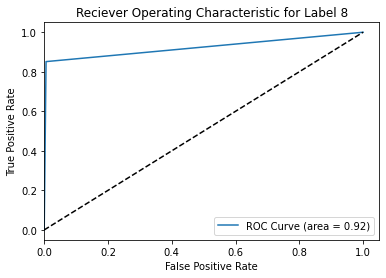

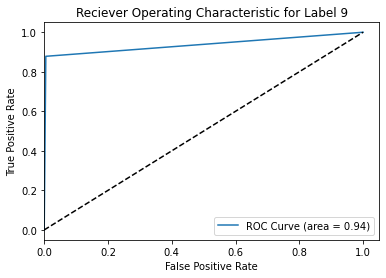

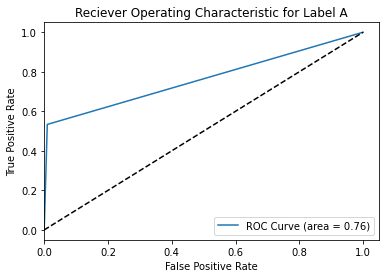

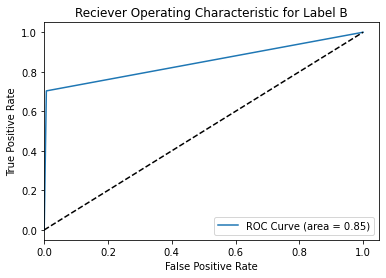

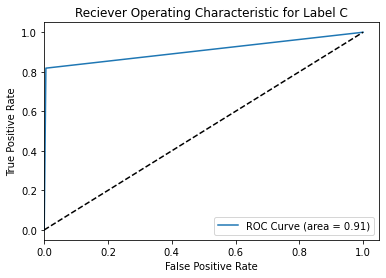

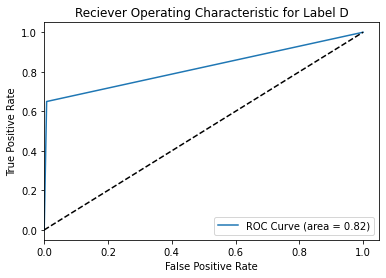

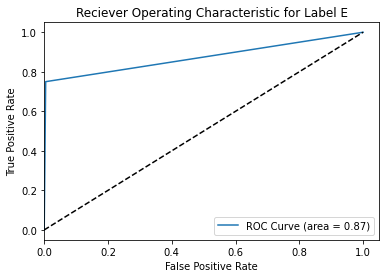

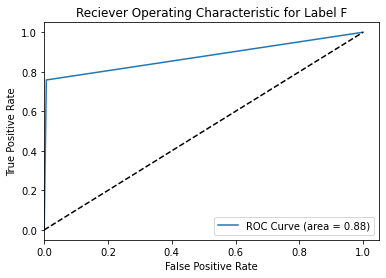

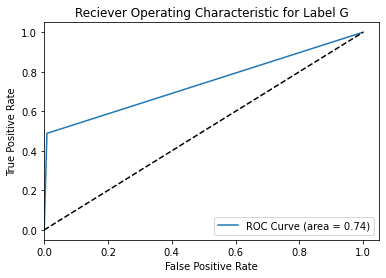

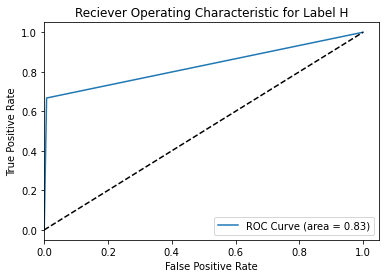

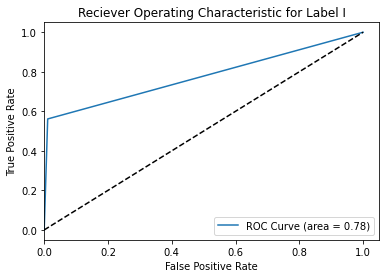

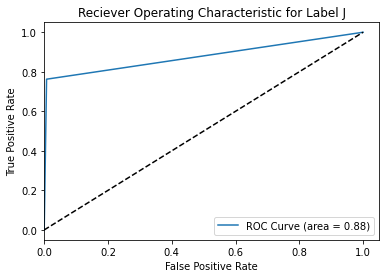

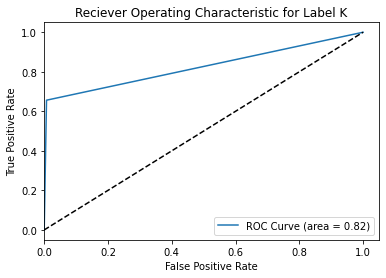

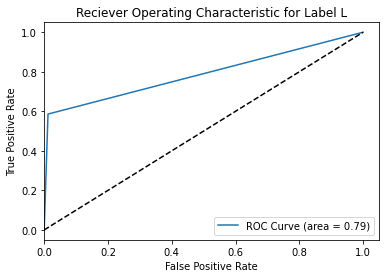

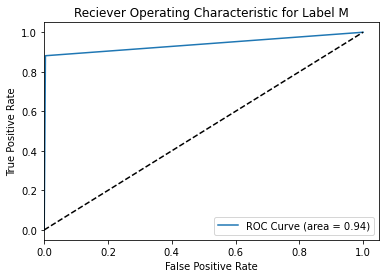

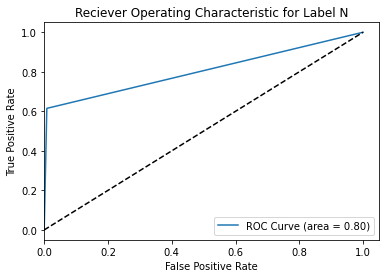

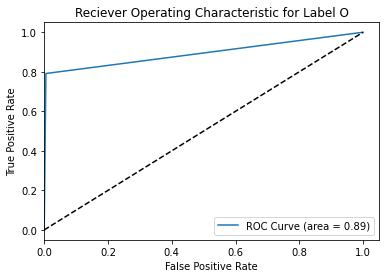

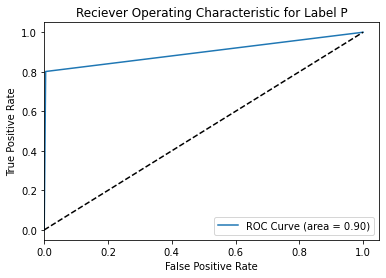

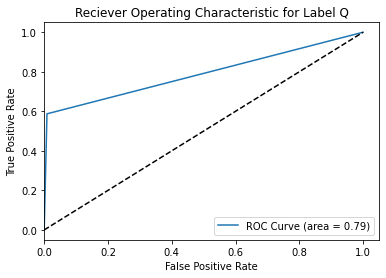

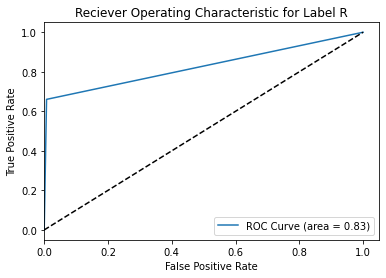

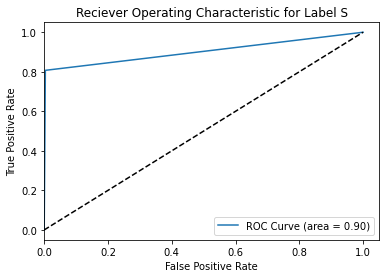

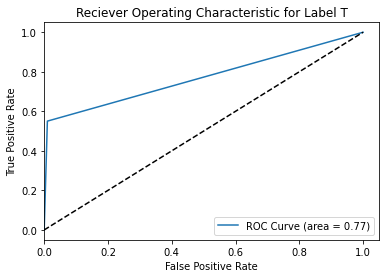

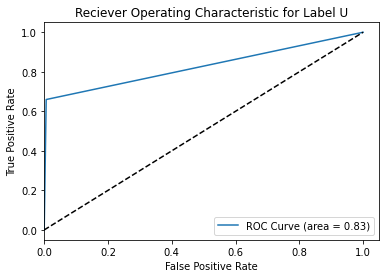

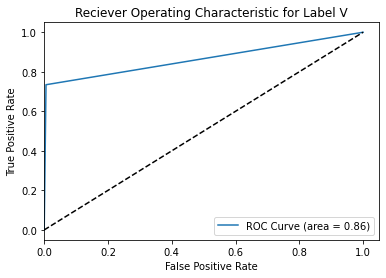

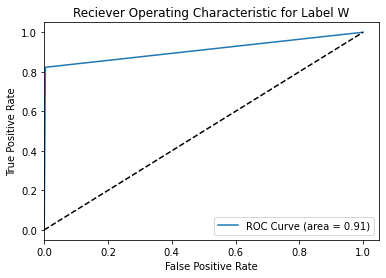

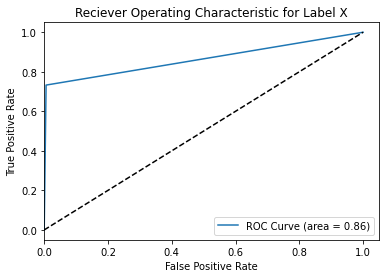

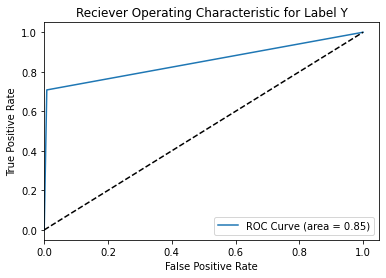

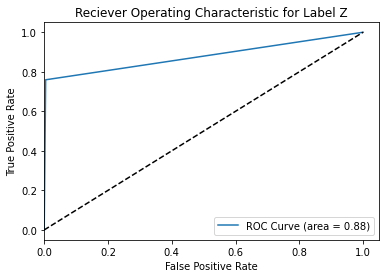

In [74]:
roc_auc(y_test_ohe, logreg_predicted_ohe, num_classes)

## Simple Neural Network

In [75]:
model = simple_nn(num_classes)
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=200, verbose=2)

accuracy = model.evaluate(X_test, y_test_ohe, verbose=0)
print('Accuracy: ', accuracy[1])

Train on 99695 samples, validate on 49104 samples
Epoch 1/10
 - 7s - loss: 0.7519 - accuracy: 0.7913 - val_loss: 0.4448 - val_accuracy: 0.8704
Epoch 2/10
 - 8s - loss: 0.3578 - accuracy: 0.8934 - val_loss: 0.3338 - val_accuracy: 0.9000
Epoch 3/10
 - 7s - loss: 0.2639 - accuracy: 0.9198 - val_loss: 0.2926 - val_accuracy: 0.9107
Epoch 4/10
 - 7s - loss: 0.2125 - accuracy: 0.9334 - val_loss: 0.2612 - val_accuracy: 0.9190
Epoch 5/10
 - 7s - loss: 0.1773 - accuracy: 0.9436 - val_loss: 0.2552 - val_accuracy: 0.9207
Epoch 6/10
 - 7s - loss: 0.1510 - accuracy: 0.9511 - val_loss: 0.2446 - val_accuracy: 0.9244
Epoch 7/10
 - 7s - loss: 0.1305 - accuracy: 0.9572 - val_loss: 0.2450 - val_accuracy: 0.9256
Epoch 8/10
 - 7s - loss: 0.1131 - accuracy: 0.9629 - val_loss: 0.2469 - val_accuracy: 0.9234
Epoch 9/10
 - 7s - loss: 0.1009 - accuracy: 0.9657 - val_loss: 0.2455 - val_accuracy: 0.9255
Epoch 10/10
 - 7s - loss: 0.0875 - accuracy: 0.9701 - val_loss: 0.2560 - val_accuracy: 0.9234
Accuracy:  0.923407

In [76]:
nn_predicted = model.predict(X_test, batch_size=200, verbose=2)
print('Accuracy: ', accuracy_score(y_test, np.argmax(nn_predicted, axis=1)))

Accuracy:  0.9234074617139133


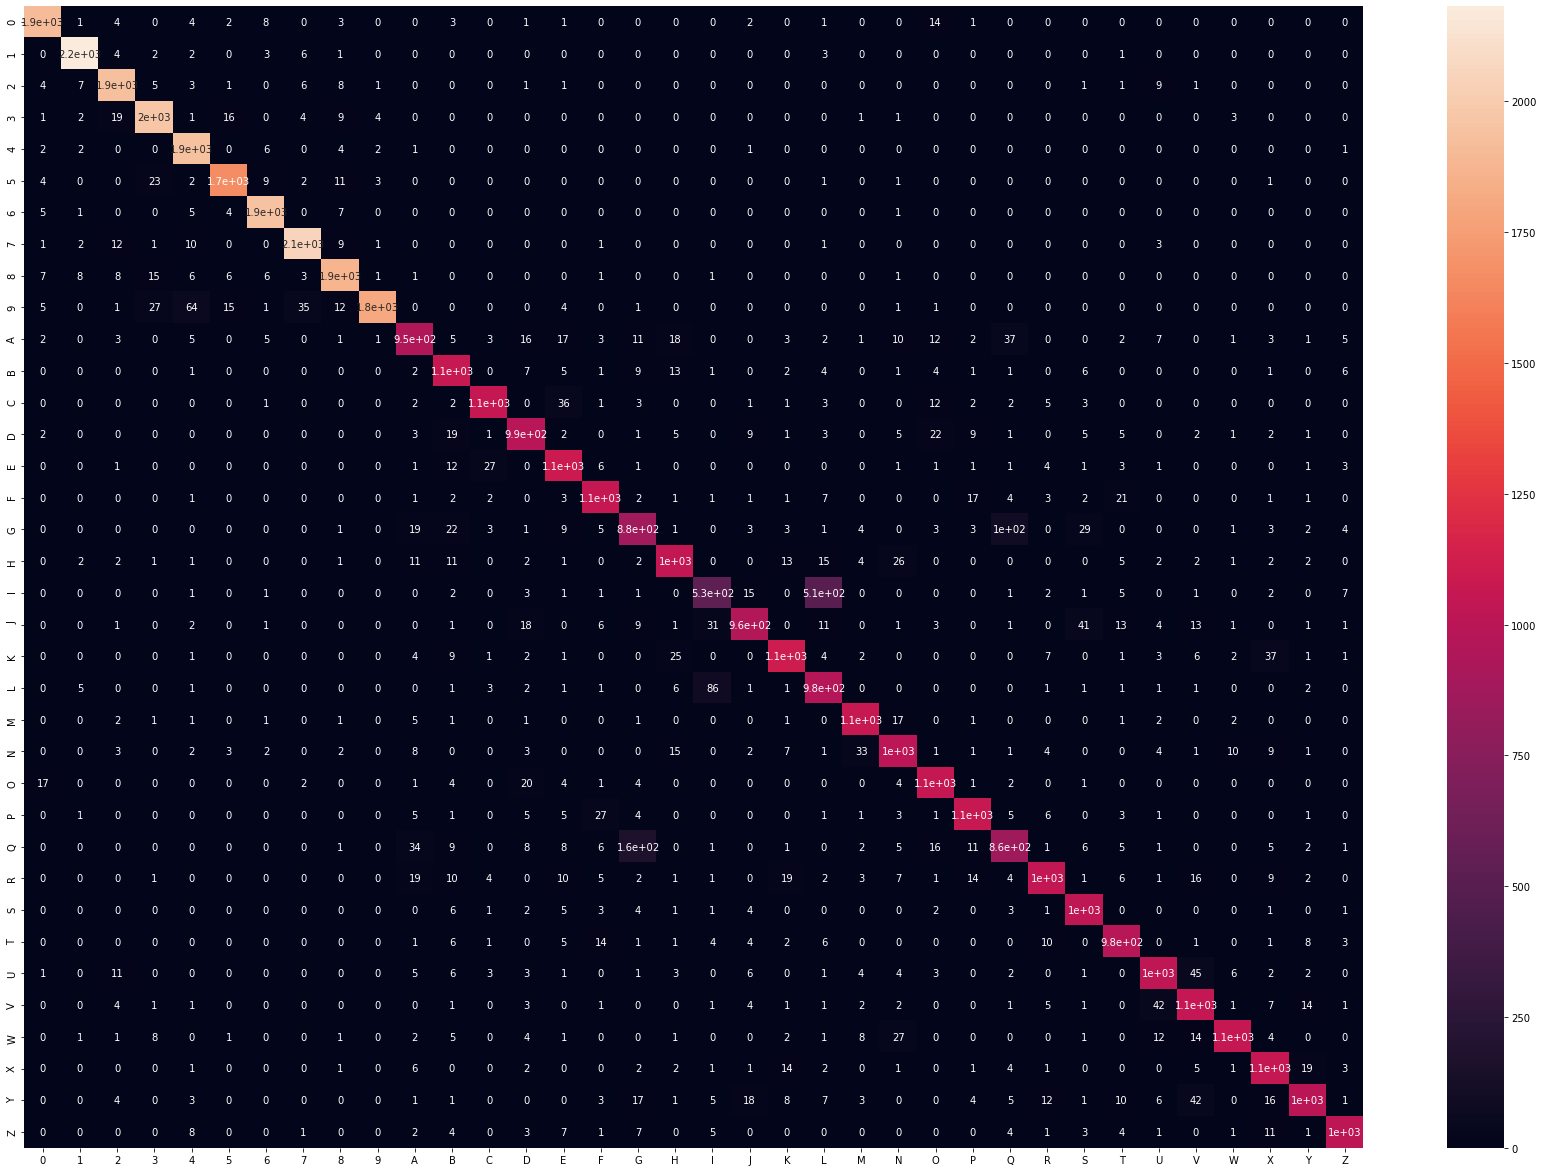

In [77]:
axis_labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
create_confusion(y_test_ohe, nn_predicted, axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.998391 (macro), 
0.998633 (weighted)

One-vs-Rest ROC AUC scores:
0.998391 (macro), 
0.998633 (weighted)


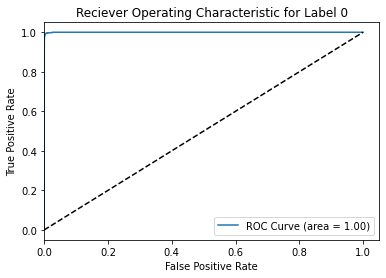

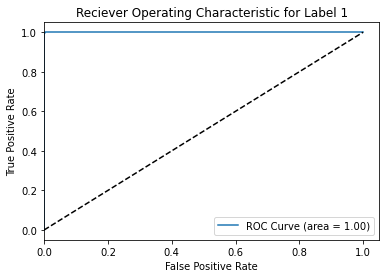

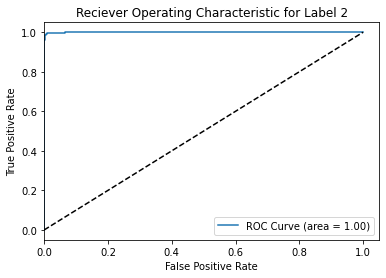

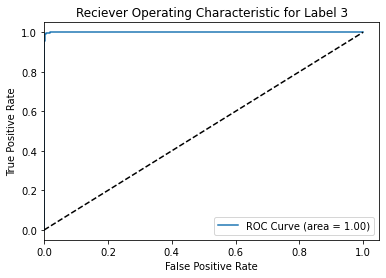

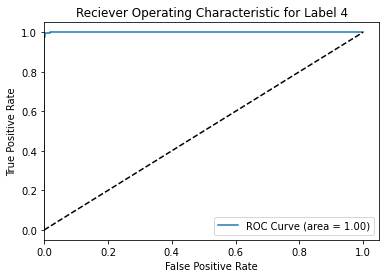

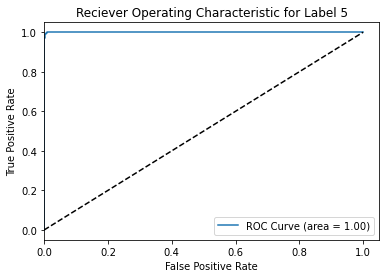

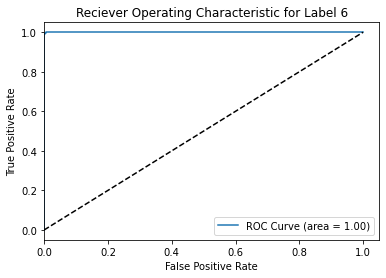

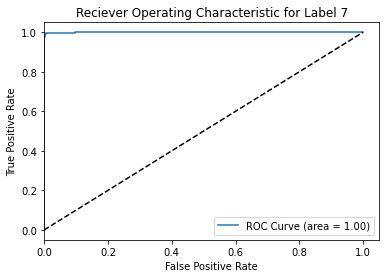

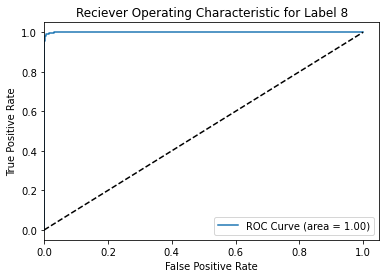

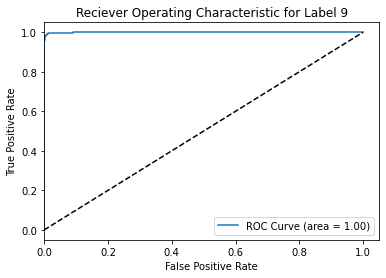

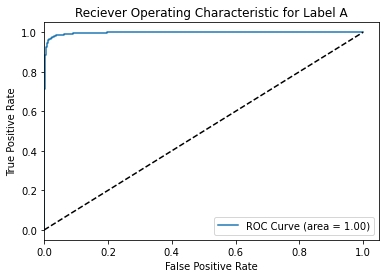

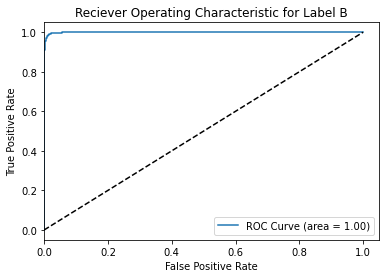

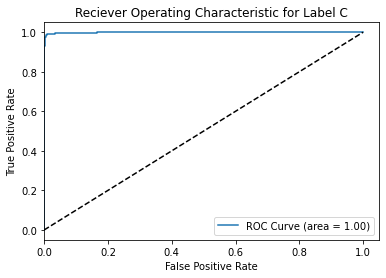

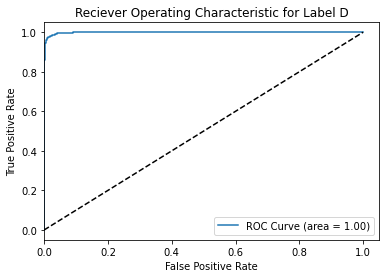

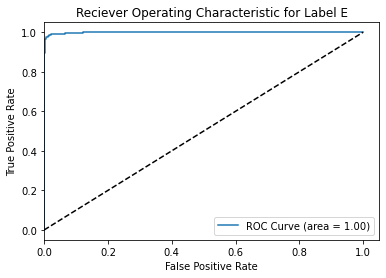

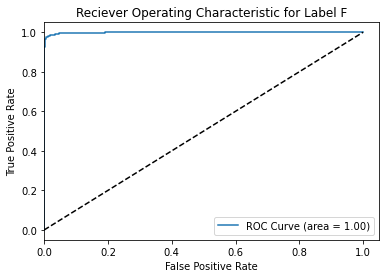

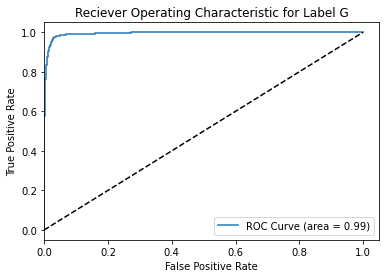

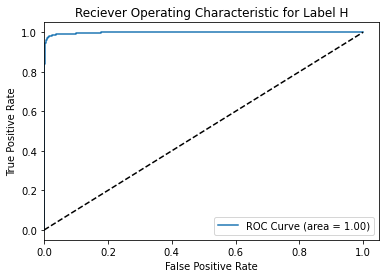

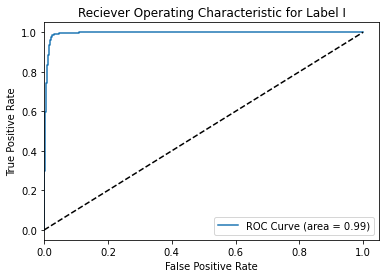

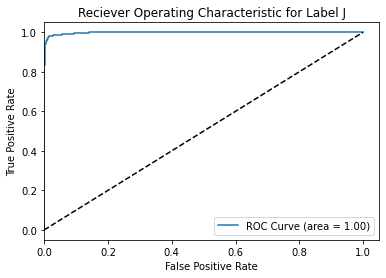

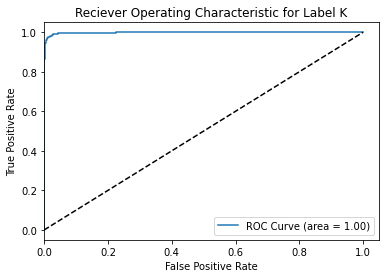

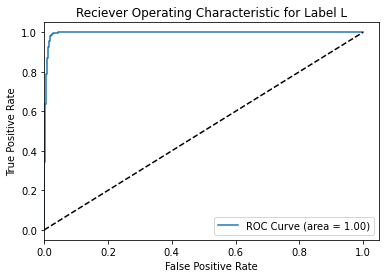

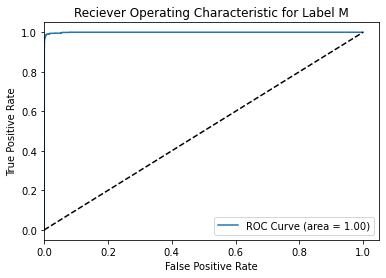

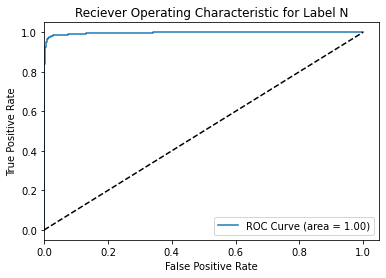

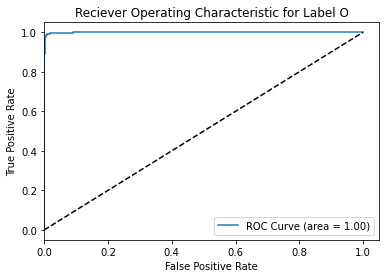

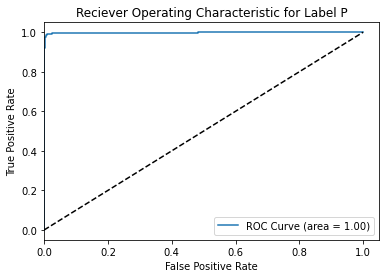

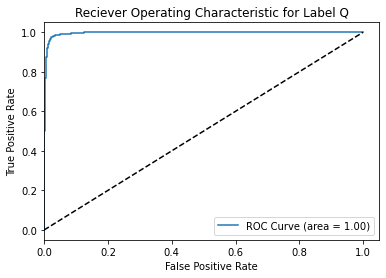

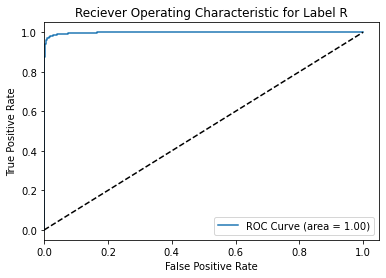

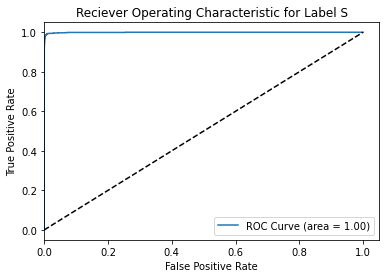

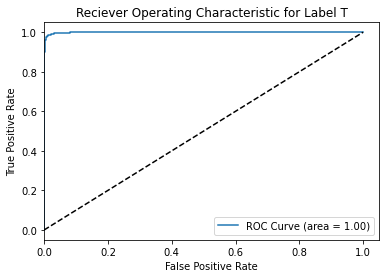

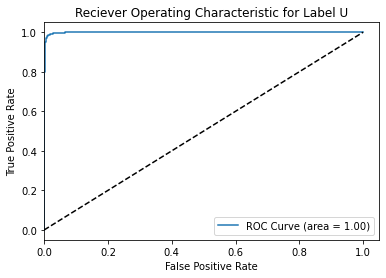

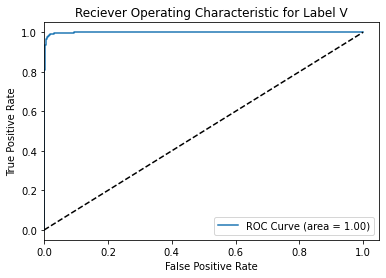

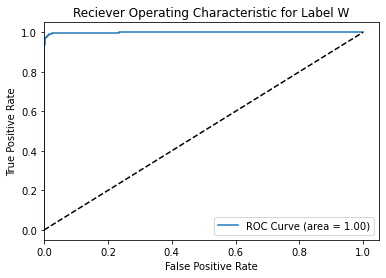

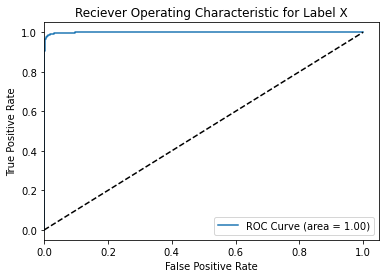

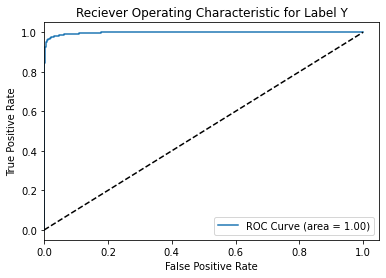

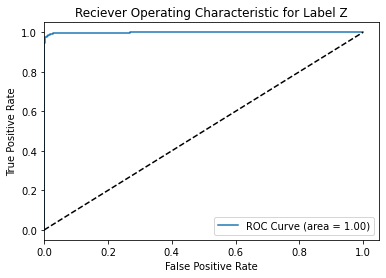

In [78]:
roc_auc(y_test_ohe, nn_predicted, num_classes)

# Image Processing

<function matplotlib.pyplot.show(close=None, block=None)>

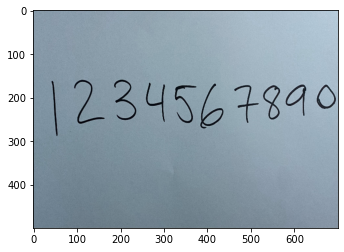

In [79]:
image = cv2.imread('number_test4.jpg')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

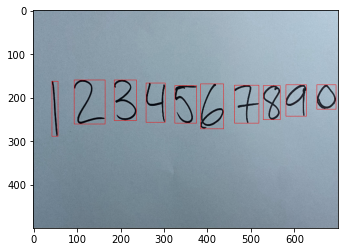

In [80]:
data, df = process_image('number_test4.jpg')

In [81]:
nn_predicted = model.predict(data, batch_size=200, verbose=2)
np.argmax(nn_predicted, axis=1)

array([ 1,  2,  3,  4,  5,  2,  3,  8, 21,  0], dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

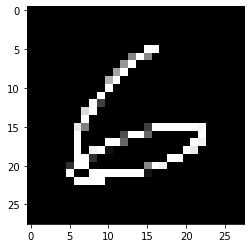

In [82]:
digits = data.reshape(10, 28, 28)
plt.imshow(digits[5], cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

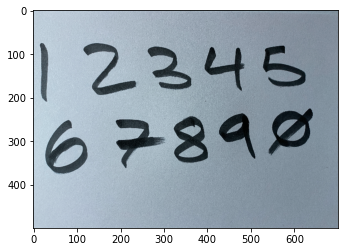

In [83]:
image = cv2.imread('number_test_rows.jpg')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

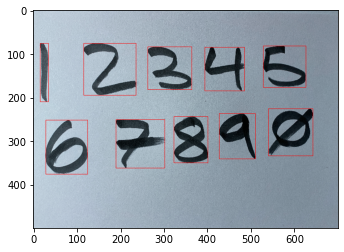

In [84]:
data, df = process_image('number_test_rows.jpg')

In [85]:
nn_predicted = model.predict(data, batch_size=200, verbose=2)
np.argmax(nn_predicted, axis=1)

array([24,  2,  2,  4,  5,  8, 31,  8, 10,  2], dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

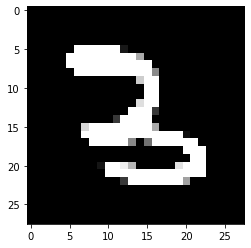

In [86]:
digits = data.reshape(10, 28, 28)
plt.imshow(digits[2], cmap='gray')
plt.show